In [135]:
import numpy as np
import matplotlib.pyplot as plt

In [136]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
from matplotlib import gridspec
from scipy import stats
from sklearn import preprocessing

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [137]:
datafile="/data0/users/bpnachman/Gaia/GD1-circle-140-30-15.pkl"
gaiadata=np.load(datafile,allow_pickle=True)
gaiadata2=np.array(gaiadata[['pmdec','pmra','dec','ra','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag']].astype('float32'))
gaiadata2 = np.vstack([gaiadata2[:,0].T,
           gaiadata2[:,1].T,
           gaiadata2[:,2].T,
           gaiadata2[:,3].T,
           (gaiadata2[:,5]-gaiadata2[:,6]).T,
           gaiadata2[:,4].T]).T
gaiadata2 = gaiadata2[np.sum(np.isnan(gaiadata2),axis=1)==0]
#if(dataset=='jhelum' or dataset=='weird'):
#    gaiadata2[:,3]=gaiadata2[:,3]-360*(gaiadata2[:,3]//180)
# Just use radius 15 circle
center_dec=0.5*(np.max(gaiadata2[:,2])+np.min(gaiadata2[:,2]))
center_ra=0.5*(np.max(gaiadata2[:,3])+np.min(gaiadata2[:,3]))
radius=np.sqrt((gaiadata2[:,2]-center_dec)**2+(gaiadata2[:,3]-center_ra)**2)
gaiadata2=gaiadata2[radius<15]
np.random.shuffle(gaiadata2)

In [138]:
gaiadata3=np.array(gaiadata[gaiadata['streammask']==1][['pmdec','pmra','dec','ra','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag']].astype('float32'))
gaiadata3 = np.vstack([gaiadata3[:,0].T,
           gaiadata3[:,1].T,
           gaiadata3[:,2].T,
           gaiadata3[:,3].T,
           (gaiadata3[:,5]-gaiadata3[:,6]).T,
           gaiadata3[:,4].T]).T
gaiadata3 = gaiadata3[np.sum(np.isnan(gaiadata3),axis=1)==0]
#if(dataset=='jhelum' or dataset=='weird'):
#    gaiadata2[:,3]=gaiadata2[:,3]-360*(gaiadata2[:,3]//180)
# Just use radius 15 circle
#center_dec=0.5*(np.max(gaiadata3[:,2])+np.min(gaiadata3[:,2]))
#center_ra=0.5*(np.max(gaiadata3[:,3])+np.min(gaiadata3[:,3]))
radius=np.sqrt((gaiadata3[:,2]-center_dec)**2+(gaiadata3[:,3]-center_ra)**2)
gaiadata3=gaiadata3[radius<15]
np.random.shuffle(gaiadata3)

In [139]:
gaiadata.keys()

Index(['source_id', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'phot_g_mean_mag', 'phot_bp_mean_mag',
       'phot_rp_mean_mag', 'bp_rp', 'radial_velocity', 'radial_velocity_error',
       'teff_val', 'streammask'],
      dtype='object')

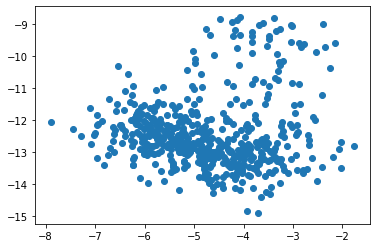

In [140]:
plt.scatter(gaiadata3[:,1],gaiadata3[:,0])

Text(0, 0.5, '$\\mu_\\delta$ [$\\mu$as/year]')

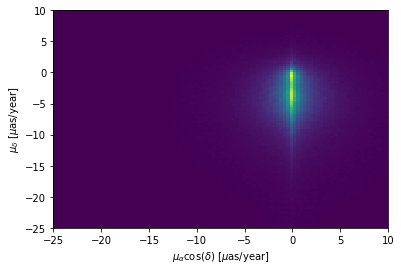

In [141]:
_,_,_,_=plt.hist2d(gaiadata2[:,1]*np.cos(gaiadata2[:,2]),gaiadata2[:,0],bins=[np.linspace(-25,10,100),np.linspace(-25,10,100)])
plt.xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]")
plt.ylabel(r"$\mu_\delta$ [$\mu$as/year]")

Text(0, 0.5, '$\\delta$ [degrees]')

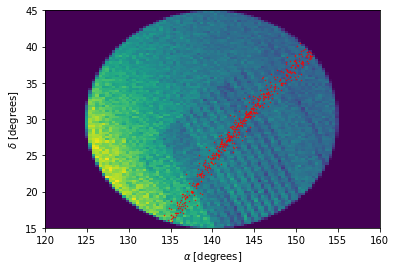

In [142]:
_,_,_,_=plt.hist2d(gaiadata2[:,3],gaiadata2[:,2],bins=[np.linspace(120,160,100),np.linspace(15,45,100)])
plt.scatter(gaiadata3[:,3],gaiadata3[:,2],color='red',s=0.2)
plt.xlabel(r"$\alpha$ [degrees]")
plt.ylabel(r"$\delta$ [degrees]")

Text(0, 0.5, '$\\delta$ [degrees]')

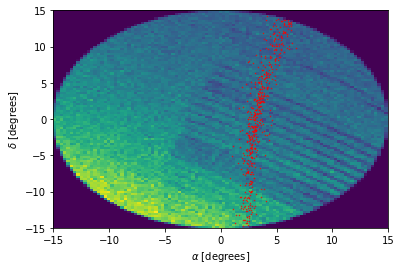

In [143]:
X = gaiadata2[:,3]-center_ra
Y = gaiadata2[:,2]-center_dec

Xs = gaiadata3[:,3]-center_ra
Ys = gaiadata3[:,2]-center_dec

theta = -0.5
Xr = X*np.cos(theta) + Y*np.sin(theta)
Yr = -X*np.sin(theta) + Y*np.cos(theta)
Xsr = Xs*np.cos(theta) + Ys*np.sin(theta)
Ysr = -Xs*np.sin(theta) + Ys*np.cos(theta)

_,_,_,_=plt.hist2d(Xr,Yr,bins=[np.linspace(-15,15,100),np.linspace(-15,15,100)])
plt.scatter(Xsr,Ysr,color='red',s=0.2)
plt.xlabel(r"$\alpha$ [degrees]")
plt.ylabel(r"$\delta$ [degrees]")

Text(0.5, 0, 'Rotated $\\delta$-$\\alpha$ space')

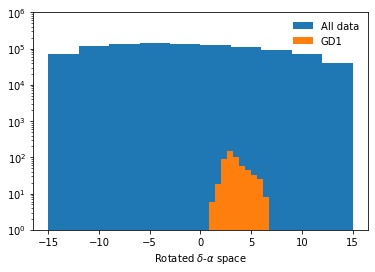

In [144]:
plt.hist(Xr,label="All data")
plt.hist(Xsr,label="GD1")
plt.yscale("log")
plt.legend(frameon=False)
plt.ylim([1,1e6])
plt.xlabel(r"Rotated $\delta$-$\alpha$ space")

Text(0.5, 0, '$\\mu_\\alpha\\cos(\\delta)$ [$\\mu$as/year]')

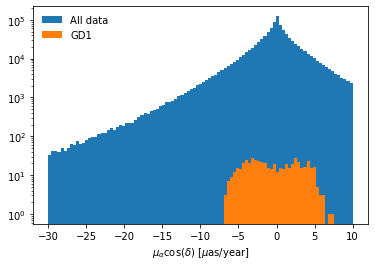

In [145]:
_,_,_=plt.hist(gaiadata2[:,1]*np.cos(gaiadata2[:,2]),bins=np.linspace(-30,10,100),label="All data")
_,_,_=plt.hist(gaiadata3[:,1]*np.cos(gaiadata3[:,2]),bins=np.linspace(-30,10,100),label="GD1")
plt.legend(frameon=False)
plt.yscale("log")
plt.xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]")

Text(0.5, 0, '$\\mu_\\delta$ [$\\mu$as/year]')

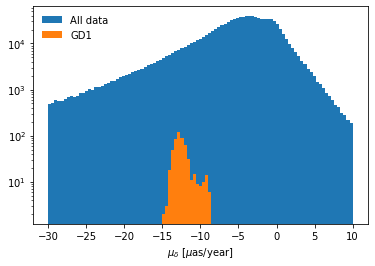

In [146]:
_,_,_=plt.hist(gaiadata2[:,0],bins=np.linspace(-30,10,100),label="All data")
_,_,_=plt.hist(gaiadata3[:,0],bins=np.linspace(-30,10,100),label="GD1")
plt.legend(frameon=False)
plt.yscale("log")
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]")

In [147]:
SR = gaiadata2[(gaiadata2[:,0] > -15)*(gaiadata2[:,0] < -11)]
SB = gaiadata2[(gaiadata2[:,0] > -18)*(gaiadata2[:,0] < -15)+(gaiadata2[:,0] > -11)*(gaiadata2[:,0] < -9.5)]
GD1 = gaiadata3

X = SR[:,3]-center_ra
Y = SR[:,2]-center_dec

#try without rotation - theta = 0
theta = -0.5
Xr = X*np.cos(theta) + Y*np.sin(theta)
Yr = -X*np.sin(theta) + Y*np.cos(theta)

Xb = SB[:,3]-center_ra
Yb = SB[:,2]-center_dec

Xbr = Xb*np.cos(theta) + Yb*np.sin(theta)
Ybr = -Xb*np.sin(theta) + Yb*np.cos(theta)

Xs = GD1[:,3]-center_ra
Ys = GD1[:,2]-center_dec

Xsr = Xs*np.cos(theta) + Ys*np.sin(theta)
Ysr = -Xs*np.sin(theta) + Ys*np.cos(theta)


#make a plot with the whole dataset and GD1 with the features in the Gaiadata set - 1D histograms, 2D scatterplots

#which measurements could I add to make SR, SB, and GD1 have more dimensions - why were these specific columns chosen?
SR = np.c_[SR[:,0],Xr,SR[:,4],SR[:,5]]
SB = np.c_[SB[:,0],Xbr,SB[:,4],SB[:,5]]
GD1 = np.c_[GD1[:,0],Xsr,GD1[:,4],GD1[:,5]]

#with rotation, add Yr
SR = np.c_[SR[:,0],Xr, Yr, SR[:,4],SR[:,5]]
SB = np.c_[SB[:,0],Xbr, Ybr, SB[:,4],SB[:,5]]
GD1 = np.c_[GD1[:,0],Xsr, Ysr, GD1[:,4],GD1[:,5]]

In [148]:
print(len(SR))
print(len(SB))

70835
71692


Text(0, 0.5, 'counts')

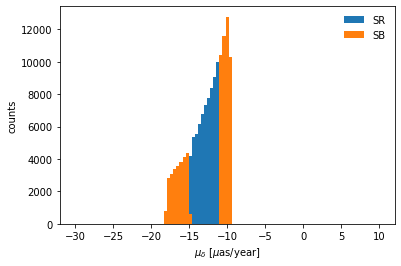

In [149]:
_,_,_=plt.hist(SR[:,0],bins=np.linspace(-30,10,100),label="SR")
_,_,_=plt.hist(SB[:,0],bins=np.linspace(-30,10,100),label="SB")
plt.legend(frameon=False)
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]")
plt.ylabel("counts")

In [150]:
X = np.concatenate([SR,SB,GD1])
Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB)),2.*np.ones(len(GD1))])
X_scaled = preprocessing.scale(X)
GD1_scaled = X_scaled[Y==2]
X_scaled = X_scaled[Y<2]
Y = Y[Y<2]
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [ ]:
model = Sequential()
model.add(Dense(64, input_dim=3, activation='relu')) 
#model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train[:,1:],Y_train, epochs=20, batch_size=200,validation_data=(X_test[:,1:],Y_test))

#what should file name be
#file name fix
file_name = '/data0/users/sowmyathanvantri/notebook_out.json'
model_json = model.to_json()
with open(file_name, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

0



Train on 71263 samples, validate on 71264 samples
Epoch 1/20
71263/71263 [==============================] - 4s 52us/step - loss: 0.6937 - acc: 0.5021 - val_loss: 0.6933 - val_acc: 0.4997
Epoch 2/20
71263/71263 [==============================] - 3s 37us/step - loss: 0.6934 - acc: 0.5008 - val_loss: 0.6931 - val_acc: 0.5008
Epoch 3/20
71263/71263 [==============================] - 3s 37us/step - loss: 0.6933 - acc: 0.5022 - val_loss: 0.6933 - val_acc: 0.4985
Epoch 4/20
71263/71263 [==============================] - 3s 37us/step - loss: 0.6932 - acc: 0.5032 - val_loss: 0.6932 - val_acc: 0.5033
Epoch 5/20
71263/71263 [==============================] - 3s 38us/step - loss: 0.6930 - acc: 0.5059 - val_loss: 0.6929 - val_acc: 0.5057
Epoch 6/20
71263/71263 [==============================] - 3s 37us/step - loss: 0.6930 - acc: 0.5058 - val_loss: 0.6930 - val_acc: 0.5011
Epoch 7/20
71263/71263 [==============================] - 3s 37us/step - loss: 0.6928 - acc: 0.5078 - val_loss: 0.6933 - va

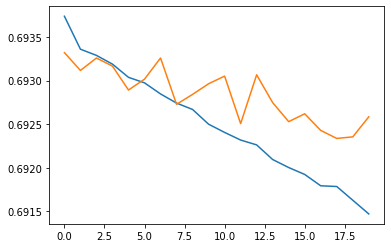

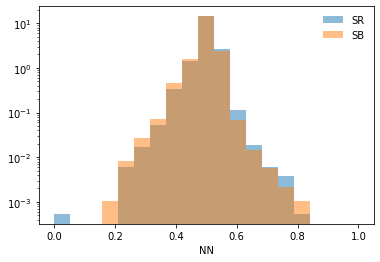

<Figure size 432x288 with 0 Axes>

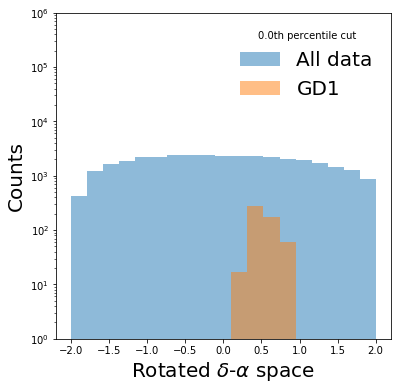

<Figure size 432x288 with 0 Axes>

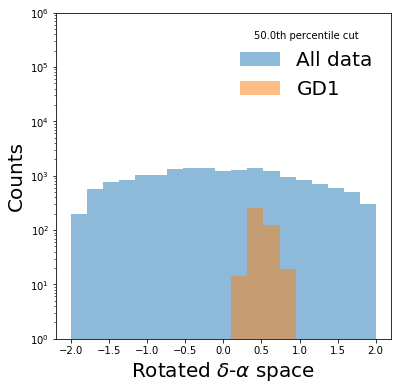

<Figure size 432x288 with 0 Axes>

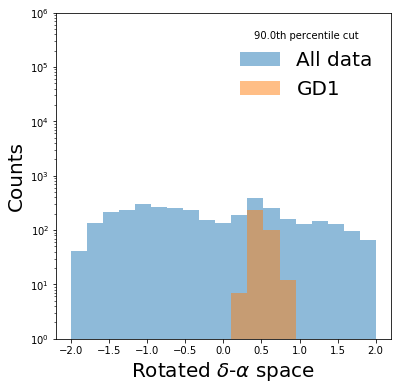

<Figure size 432x288 with 0 Axes>

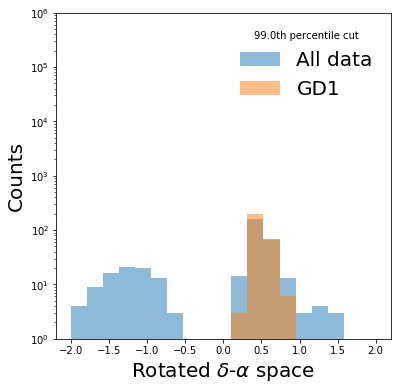

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


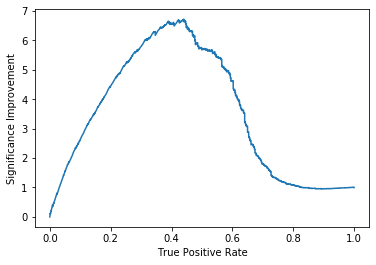

<Figure size 432x288 with 0 Axes>

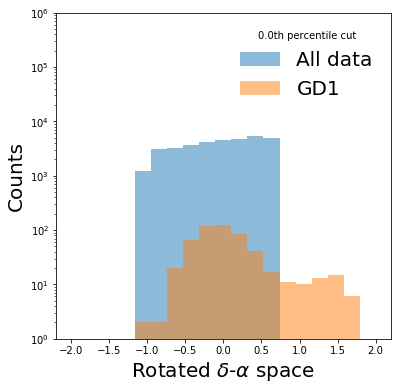

<Figure size 432x288 with 0 Axes>

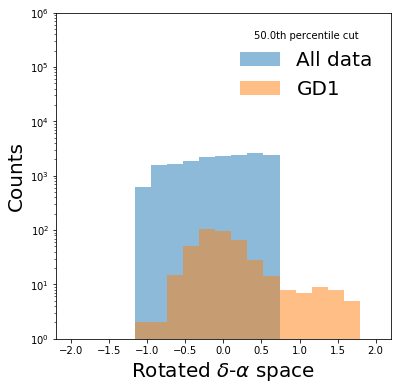

<Figure size 432x288 with 0 Axes>

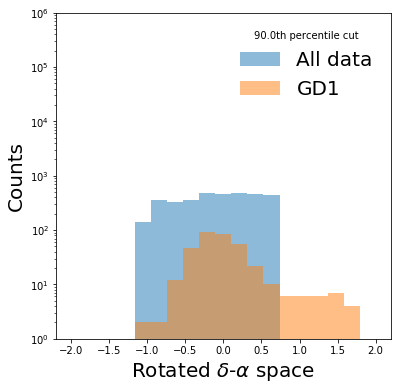

<Figure size 432x288 with 0 Axes>

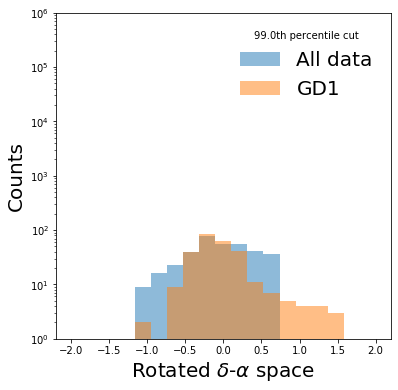







1



Train on 71263 samples, validate on 71264 samples
Epoch 1/20
71263/71263 [==============================] - 4s 52us/step - loss: 0.6936 - acc: 0.4978 - val_loss: 0.6931 - val_acc: 0.5055
Epoch 2/20
71263/71263 [==============================] - 3s 37us/step - loss: 0.6933 - acc: 0.5011 - val_loss: 0.6930 - val_acc: 0.5055
Epoch 3/20
71263/71263 [==============================] - 3s 37us/step - loss: 0.6931 - acc: 0.5049 - val_loss: 0.6933 - val_acc: 0.4996
Epoch 4/20
71263/71263 [==============================] - 3s 36us/step - loss: 0.6932 - acc: 0.5015 - val_loss: 0.6930 - val_acc: 0.5067
Epoch 5/20
71263/71263 [==============================] - 3s 38us/step - loss: 0.6931 - acc: 0.5046 - val_loss: 0.6930 - val_acc: 0.5074
Epoch 6/20
71263/71263 [==============================] - 3s 37us/step - loss: 0.6930 - acc: 0.5068 - val_loss: 0.6929 - val_acc: 0.5075
Epoch 7/20
71263/71263 [==============================] - 3s 37us/step - loss: 0.6929 - acc: 0.5071 - val_loss: 0.692

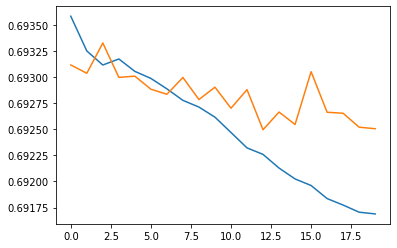

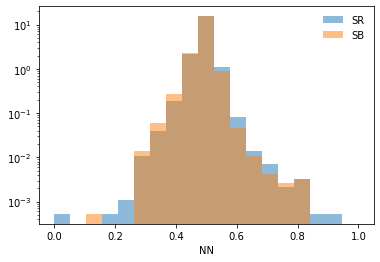

<Figure size 432x288 with 0 Axes>

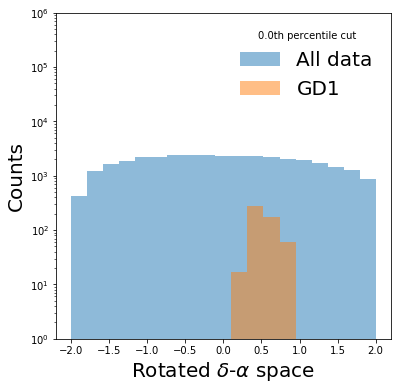

<Figure size 432x288 with 0 Axes>

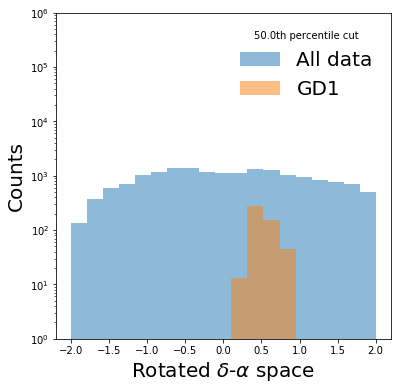

<Figure size 432x288 with 0 Axes>

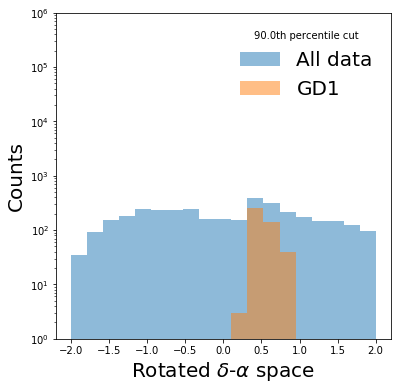

<Figure size 432x288 with 0 Axes>

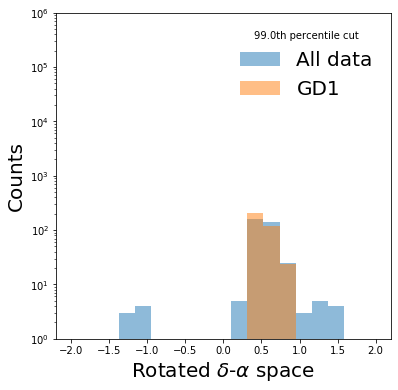

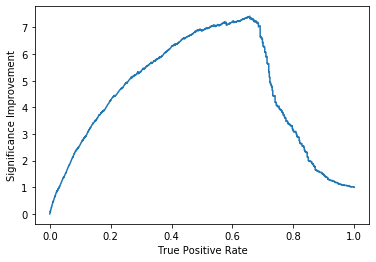

<Figure size 432x288 with 0 Axes>

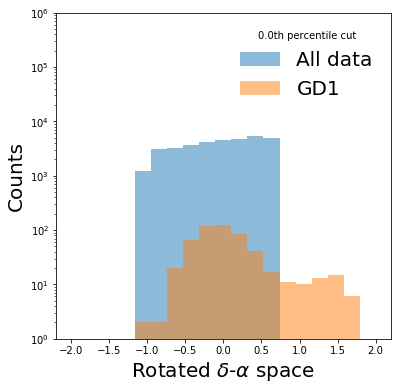

<Figure size 432x288 with 0 Axes>

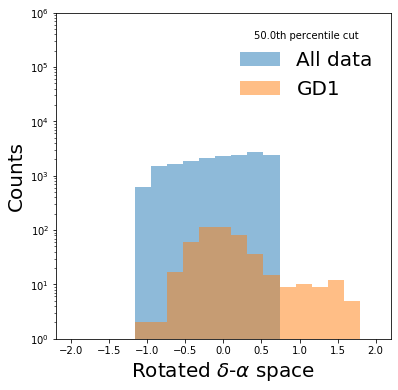

<Figure size 432x288 with 0 Axes>

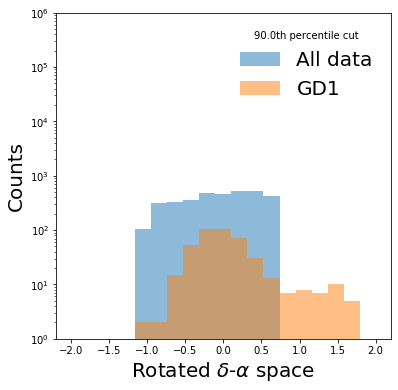

<Figure size 432x288 with 0 Axes>

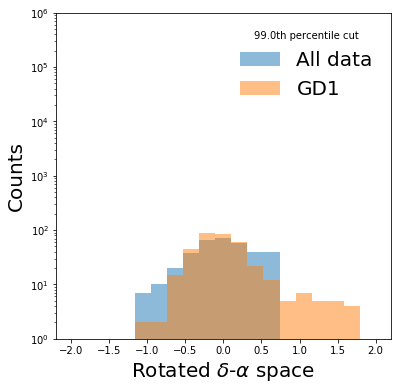







2



Train on 71263 samples, validate on 71264 samples
Epoch 1/20
71263/71263 [==============================] - 4s 55us/step - loss: 0.6936 - acc: 0.5005 - val_loss: 0.6933 - val_acc: 0.5004
Epoch 2/20
71263/71263 [==============================] - 3s 37us/step - loss: 0.6933 - acc: 0.5023 - val_loss: 0.6933 - val_acc: 0.5022
Epoch 3/20
71263/71263 [==============================] - 3s 38us/step - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6931 - val_acc: 0.5016
Epoch 4/20
71263/71263 [==============================] - 3s 36us/step - loss: 0.6931 - acc: 0.5055 - val_loss: 0.6933 - val_acc: 0.4985
Epoch 5/20
71263/71263 [==============================] - 3s 38us/step - loss: 0.6930 - acc: 0.5043 - val_loss: 0.6931 - val_acc: 0.5008
Epoch 6/20
71263/71263 [==============================] - 3s 37us/step - loss: 0.6929 - acc: 0.5054 - val_loss: 0.6932 - val_acc: 0.5007
Epoch 7/20
71263/71263 [==============================] - 3s 37us/step - loss: 0.6929 - acc: 0.5095 - val_loss: 0.692

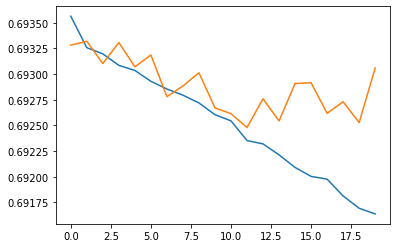

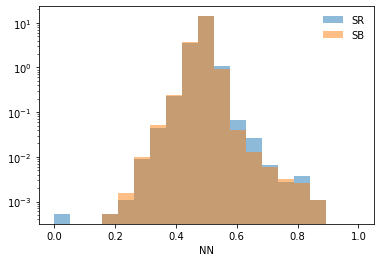

<Figure size 432x288 with 0 Axes>

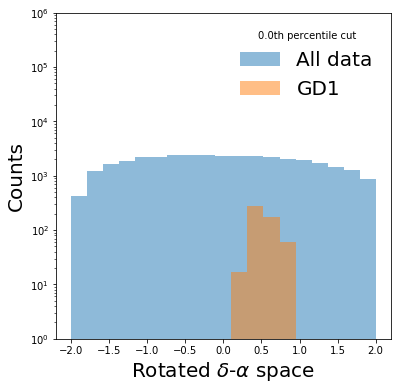

<Figure size 432x288 with 0 Axes>

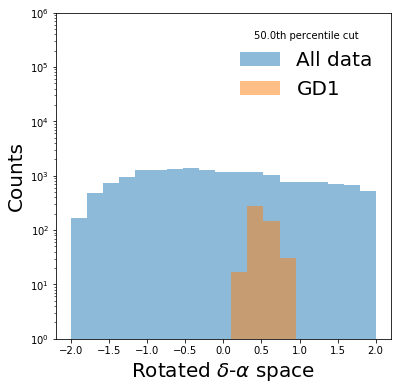

<Figure size 432x288 with 0 Axes>

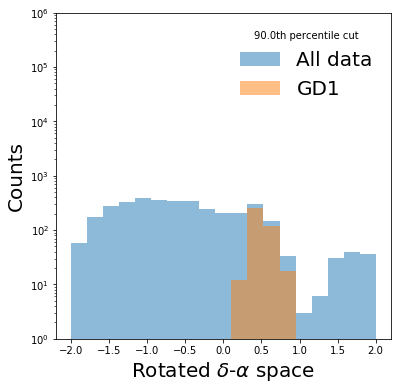

<Figure size 432x288 with 0 Axes>

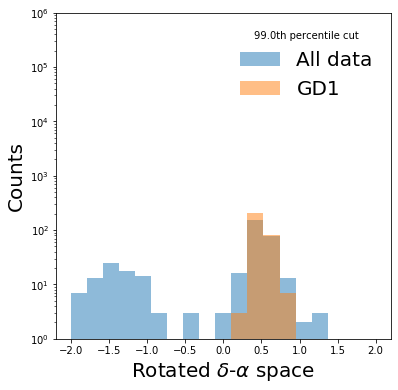

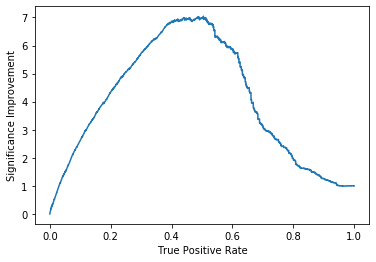

<Figure size 432x288 with 0 Axes>

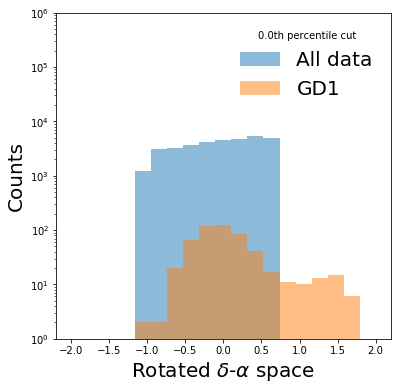

<Figure size 432x288 with 0 Axes>

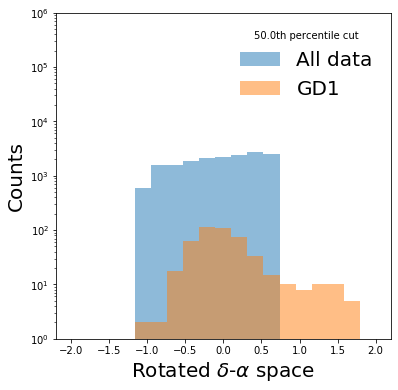

<Figure size 432x288 with 0 Axes>

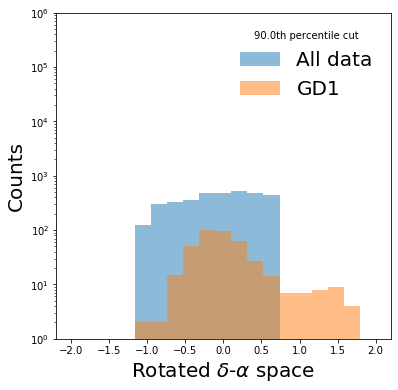

<Figure size 432x288 with 0 Axes>

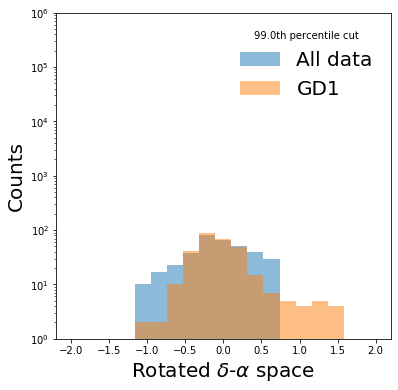







3



Train on 71263 samples, validate on 71264 samples
Epoch 1/20
71263/71263 [==============================] - 4s 55us/step - loss: 0.6937 - acc: 0.4992 - val_loss: 0.6931 - val_acc: 0.5042
Epoch 2/20
71263/71263 [==============================] - 3s 39us/step - loss: 0.6933 - acc: 0.5025 - val_loss: 0.6931 - val_acc: 0.5055
Epoch 3/20
71263/71263 [==============================] - 3s 38us/step - loss: 0.6933 - acc: 0.5028 - val_loss: 0.6937 - val_acc: 0.4988
Epoch 4/20
71263/71263 [==============================] - 3s 37us/step - loss: 0.6931 - acc: 0.5039 - val_loss: 0.6930 - val_acc: 0.5071
Epoch 5/20
71263/71263 [==============================] - 3s 38us/step - loss: 0.6931 - acc: 0.5044 - val_loss: 0.6930 - val_acc: 0.5056
Epoch 6/20
71263/71263 [==============================] - 3s 37us/step - loss: 0.6930 - acc: 0.5062 - val_loss: 0.6930 - val_acc: 0.5066
Epoch 7/20
71263/71263 [==============================] - 3s 37us/step - loss: 0.6929 - acc: 0.5079 - val_loss: 0.693

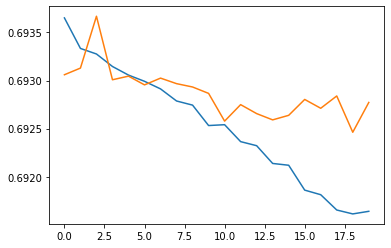

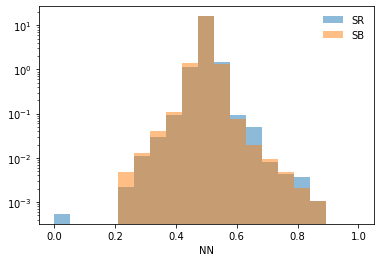

<Figure size 432x288 with 0 Axes>

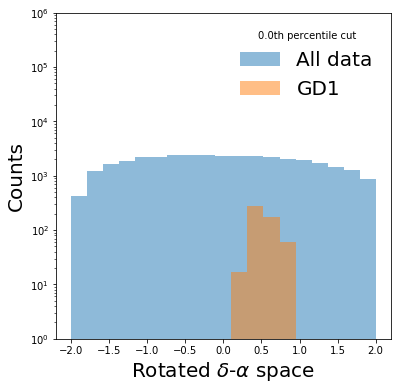

<Figure size 432x288 with 0 Axes>

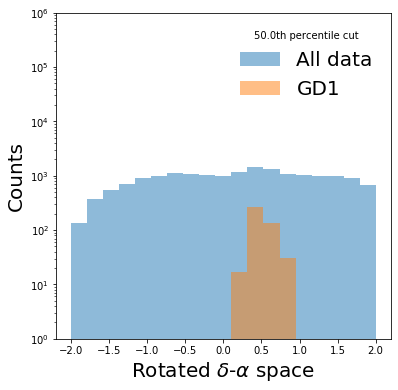

<Figure size 432x288 with 0 Axes>

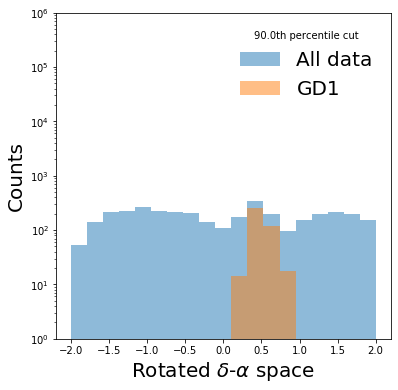

<Figure size 432x288 with 0 Axes>

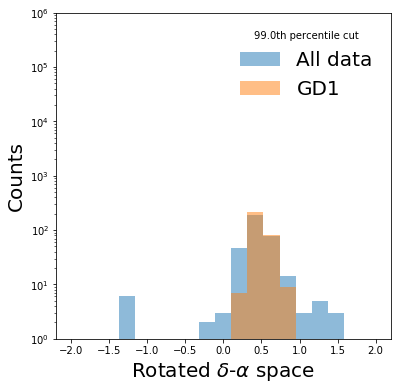

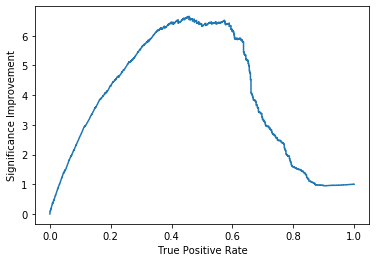

<Figure size 432x288 with 0 Axes>

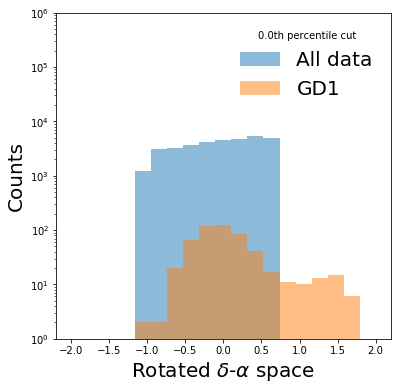

<Figure size 432x288 with 0 Axes>

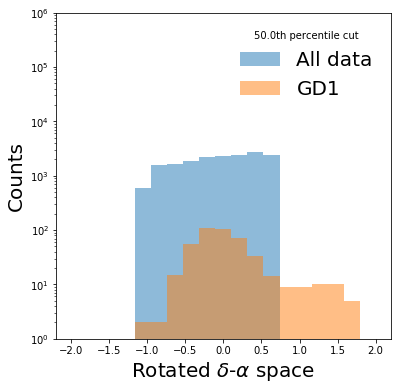

<Figure size 432x288 with 0 Axes>

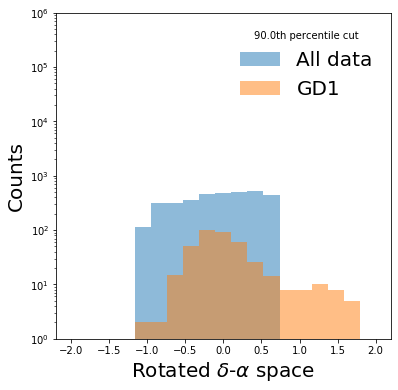

<Figure size 432x288 with 0 Axes>

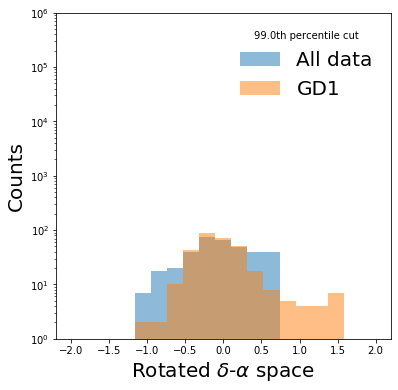







4



Train on 71263 samples, validate on 71264 samples
Epoch 1/20
71263/71263 [==============================] - 4s 55us/step - loss: 0.6938 - acc: 0.4966 - val_loss: 0.6931 - val_acc: 0.5064
Epoch 2/20
71263/71263 [==============================] - 3s 39us/step - loss: 0.6934 - acc: 0.4993 - val_loss: 0.6931 - val_acc: 0.5041
Epoch 3/20
71263/71263 [==============================] - 3s 38us/step - loss: 0.6932 - acc: 0.5011 - val_loss: 0.6932 - val_acc: 0.5021
Epoch 4/20
71263/71263 [==============================] - 3s 39us/step - loss: 0.6931 - acc: 0.5046 - val_loss: 0.6931 - val_acc: 0.5046
Epoch 5/20
71263/71263 [==============================] - 3s 38us/step - loss: 0.6931 - acc: 0.5045 - val_loss: 0.6931 - val_acc: 0.5039
Epoch 6/20
71263/71263 [==============================] - 3s 38us/step - loss: 0.6931 - acc: 0.5035 - val_loss: 0.6931 - val_acc: 0.5048
Epoch 7/20
71263/71263 [==============================] - 3s 38us/step - loss: 0.6930 - acc: 0.5066 - val_loss: 0.693

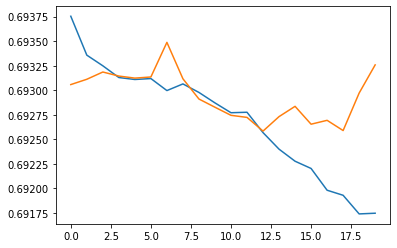

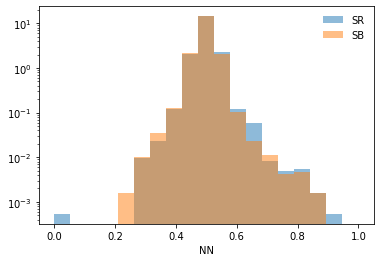

<Figure size 432x288 with 0 Axes>

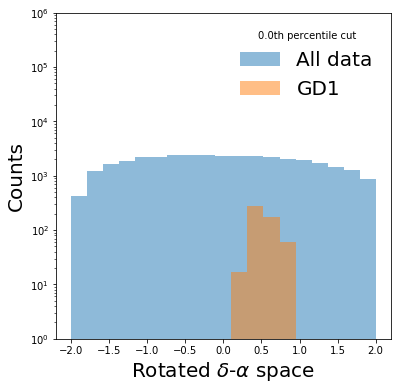

<Figure size 432x288 with 0 Axes>

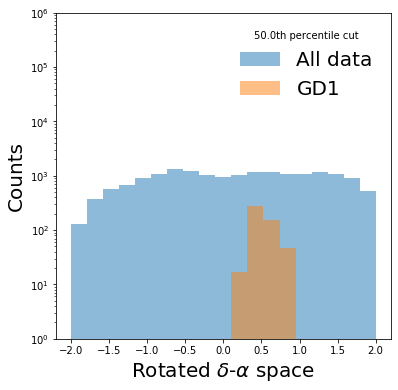

<Figure size 432x288 with 0 Axes>

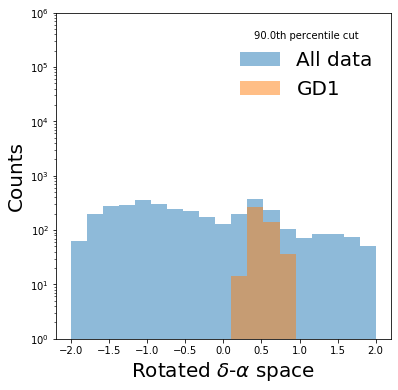

<Figure size 432x288 with 0 Axes>

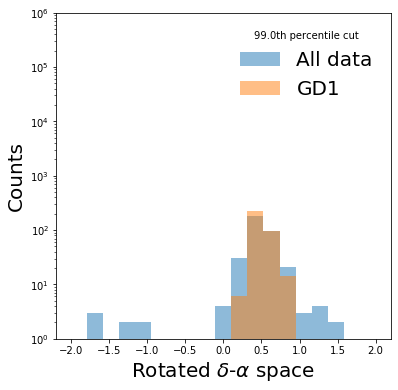

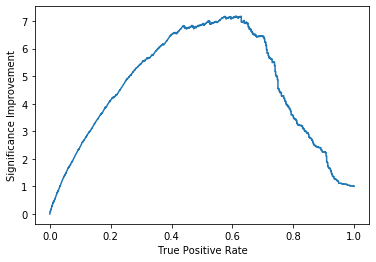

<Figure size 432x288 with 0 Axes>

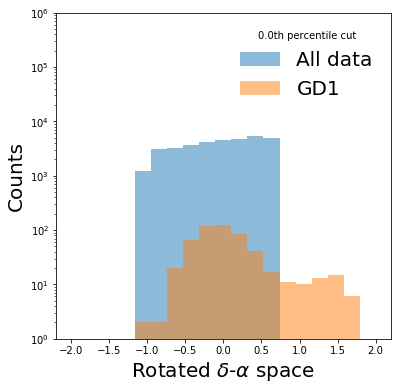

<Figure size 432x288 with 0 Axes>

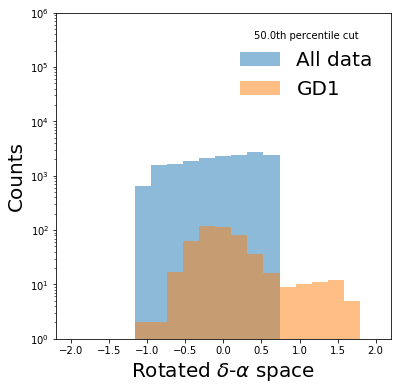

<Figure size 432x288 with 0 Axes>

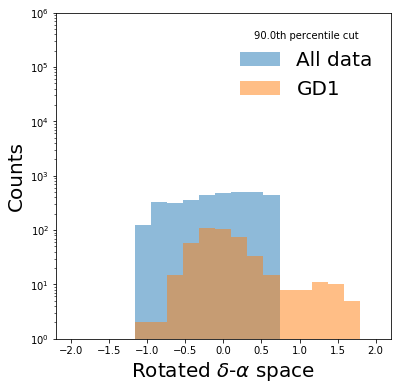

<Figure size 432x288 with 0 Axes>

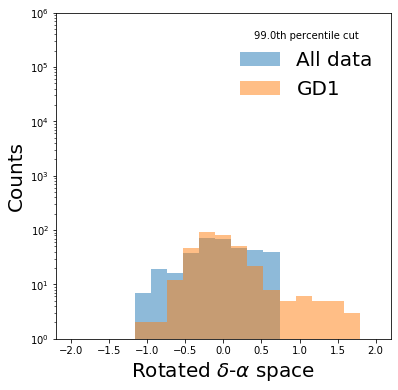







5



Train on 71263 samples, validate on 71264 samples
Epoch 1/20
71263/71263 [==============================] - 4s 57us/step - loss: 0.6938 - acc: 0.4981 - val_loss: 0.6931 - val_acc: 0.5037
Epoch 2/20
71263/71263 [==============================] - 3s 38us/step - loss: 0.6933 - acc: 0.5028 - val_loss: 0.6931 - val_acc: 0.5045
Epoch 3/20
71263/71263 [==============================] - 3s 38us/step - loss: 0.6932 - acc: 0.5025 - val_loss: 0.6933 - val_acc: 0.5011
Epoch 4/20
71263/71263 [==============================] - 3s 39us/step - loss: 0.6932 - acc: 0.5030 - val_loss: 0.6929 - val_acc: 0.5089
Epoch 5/20
71263/71263 [==============================] - 3s 37us/step - loss: 0.6930 - acc: 0.5072 - val_loss: 0.6930 - val_acc: 0.5021
Epoch 6/20
71263/71263 [==============================] - 3s 39us/step - loss: 0.6929 - acc: 0.5054 - val_loss: 0.6930 - val_acc: 0.5032
Epoch 7/20
71263/71263 [==============================] - 3s 39us/step - loss: 0.6928 - acc: 0.5073 - val_loss: 0.693

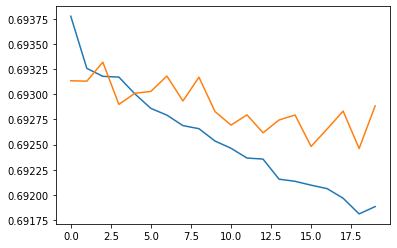

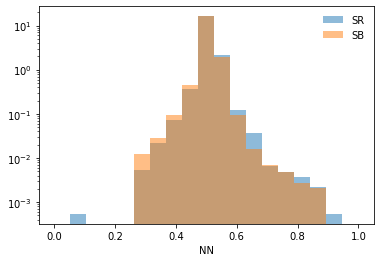

<Figure size 432x288 with 0 Axes>

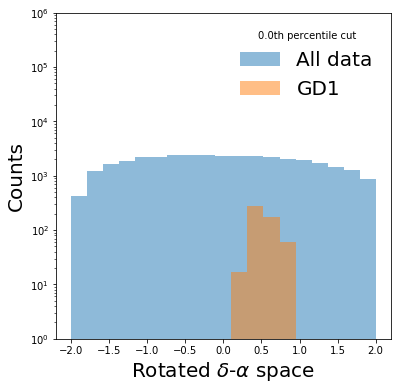

<Figure size 432x288 with 0 Axes>

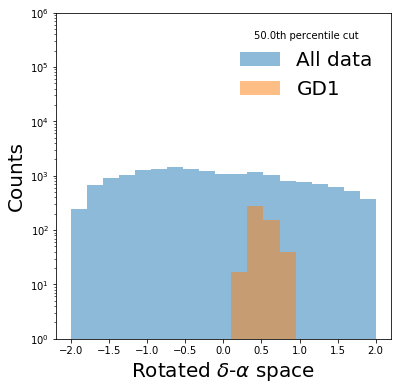

<Figure size 432x288 with 0 Axes>

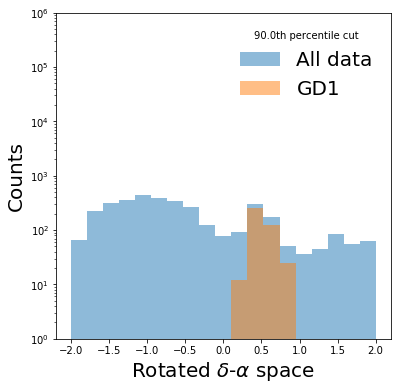

<Figure size 432x288 with 0 Axes>

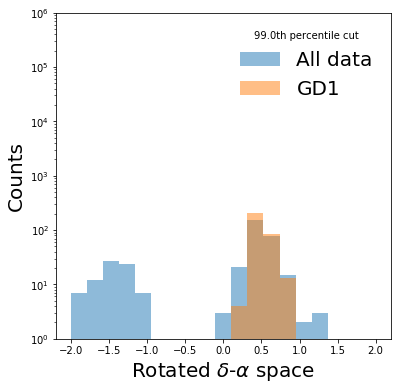

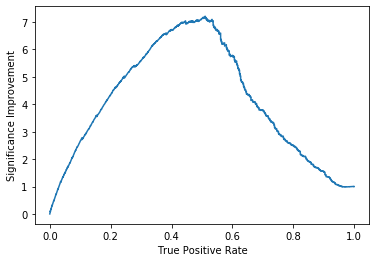

<Figure size 432x288 with 0 Axes>

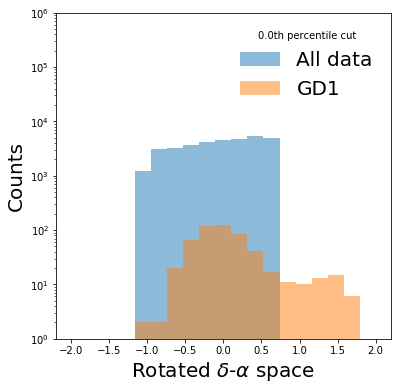

<Figure size 432x288 with 0 Axes>

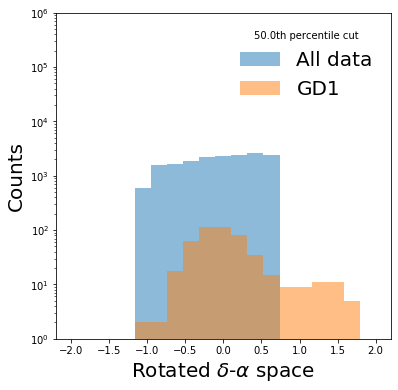

<Figure size 432x288 with 0 Axes>

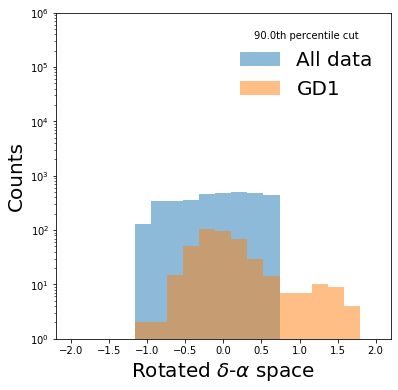

<Figure size 432x288 with 0 Axes>

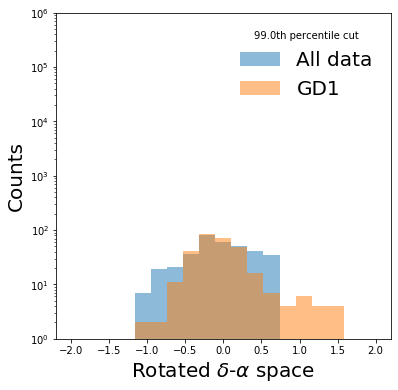







6



Train on 71263 samples, validate on 71264 samples
Epoch 1/20
71263/71263 [==============================] - 4s 57us/step - loss: 0.6938 - acc: 0.4998 - val_loss: 0.6939 - val_acc: 0.4995
Epoch 2/20
71263/71263 [==============================] - 3s 39us/step - loss: 0.6933 - acc: 0.5000 - val_loss: 0.6930 - val_acc: 0.5056
Epoch 3/20
71263/71263 [==============================] - 3s 38us/step - loss: 0.6932 - acc: 0.5028 - val_loss: 0.6931 - val_acc: 0.5063
Epoch 4/20
71263/71263 [==============================] - 3s 39us/step - loss: 0.6931 - acc: 0.4999 - val_loss: 0.6930 - val_acc: 0.5074
Epoch 5/20
71263/71263 [==============================] - 3s 40us/step - loss: 0.6930 - acc: 0.5030 - val_loss: 0.6930 - val_acc: 0.5033
Epoch 6/20
71263/71263 [==============================] - 3s 39us/step - loss: 0.6930 - acc: 0.5023 - val_loss: 0.6930 - val_acc: 0.5064
Epoch 7/20
71263/71263 [==============================] - 3s 39us/step - loss: 0.6928 - acc: 0.5051 - val_loss: 0.693

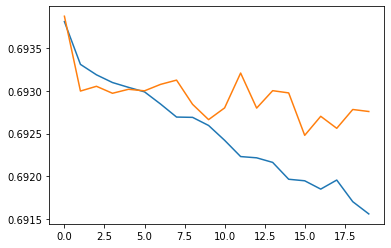

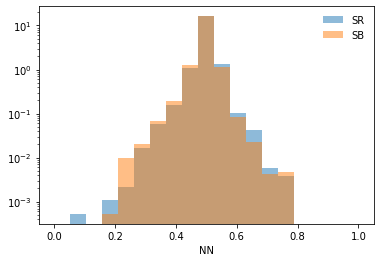

<Figure size 432x288 with 0 Axes>

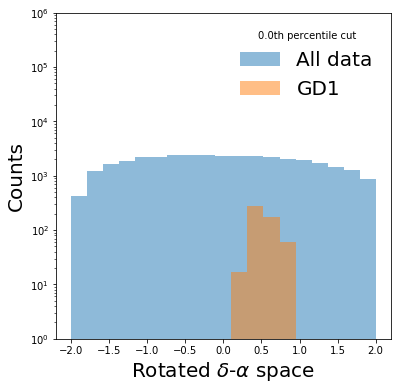

<Figure size 432x288 with 0 Axes>

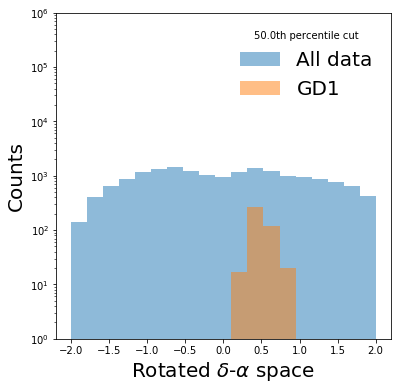

<Figure size 432x288 with 0 Axes>

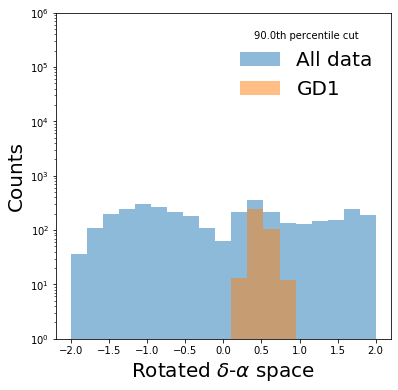

<Figure size 432x288 with 0 Axes>

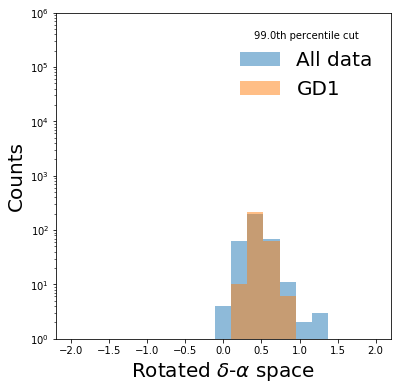

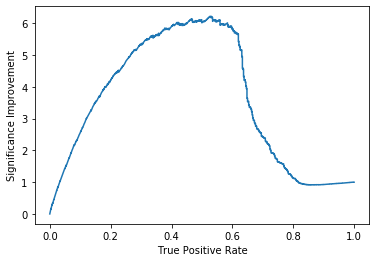

<Figure size 432x288 with 0 Axes>

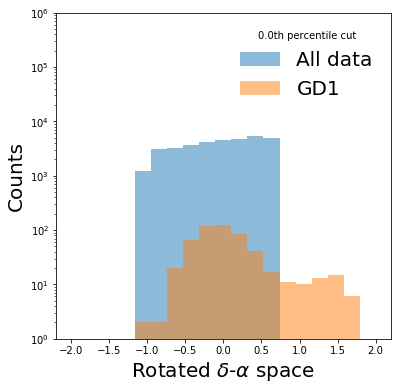

<Figure size 432x288 with 0 Axes>

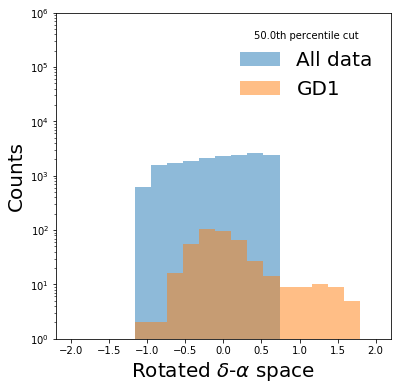

<Figure size 432x288 with 0 Axes>

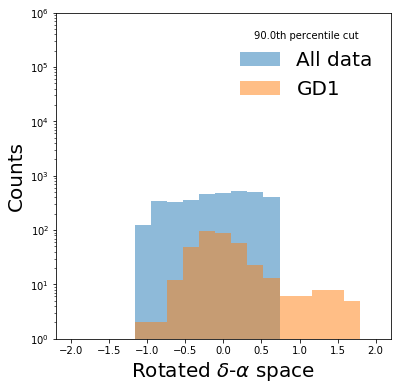

<Figure size 432x288 with 0 Axes>

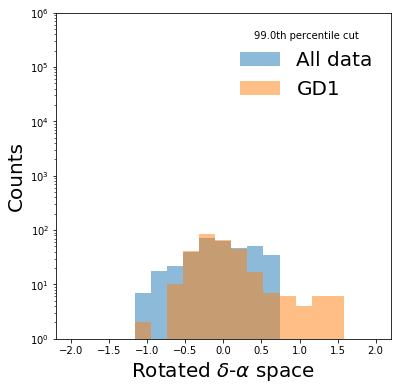







7



Train on 71263 samples, validate on 71264 samples
Epoch 1/20
71263/71263 [==============================] - 4s 60us/step - loss: 0.6939 - acc: 0.4964 - val_loss: 0.6933 - val_acc: 0.5035
Epoch 2/20
71263/71263 [==============================] - 3s 39us/step - loss: 0.6934 - acc: 0.4999 - val_loss: 0.6931 - val_acc: 0.5029
Epoch 3/20
71263/71263 [==============================] - 3s 39us/step - loss: 0.6932 - acc: 0.5011 - val_loss: 0.6930 - val_acc: 0.5060
Epoch 4/20
71263/71263 [==============================] - 3s 38us/step - loss: 0.6932 - acc: 0.5035 - val_loss: 0.6933 - val_acc: 0.4998
Epoch 5/20
71263/71263 [==============================] - 3s 39us/step - loss: 0.6932 - acc: 0.5063 - val_loss: 0.6932 - val_acc: 0.5061
Epoch 6/20
71263/71263 [==============================] - 3s 40us/step - loss: 0.6931 - acc: 0.5042 - val_loss: 0.6931 - val_acc: 0.5018
Epoch 7/20
71263/71263 [==============================] - 3s 38us/step - loss: 0.6930 - acc: 0.5061 - val_loss: 0.693

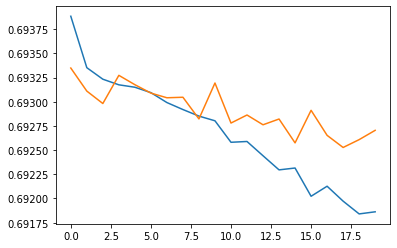

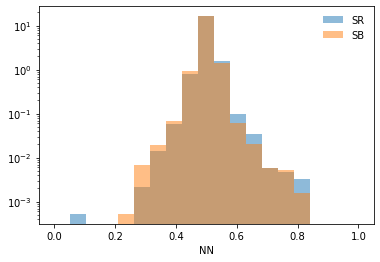

<Figure size 432x288 with 0 Axes>

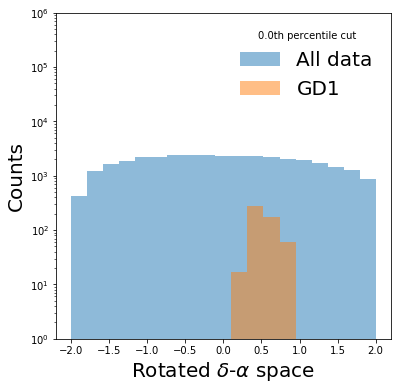

<Figure size 432x288 with 0 Axes>

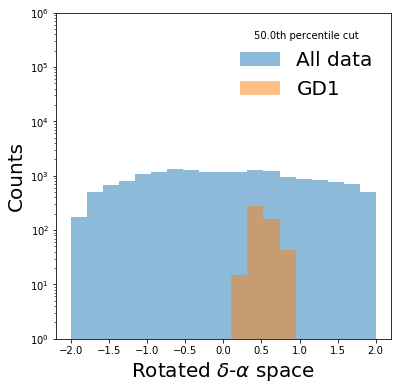

<Figure size 432x288 with 0 Axes>

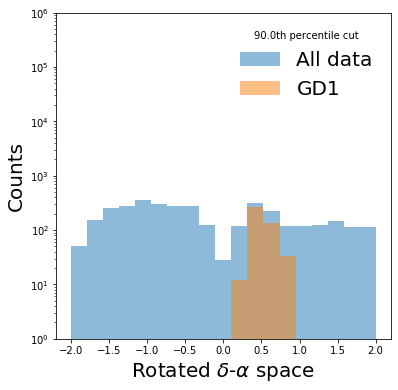

<Figure size 432x288 with 0 Axes>

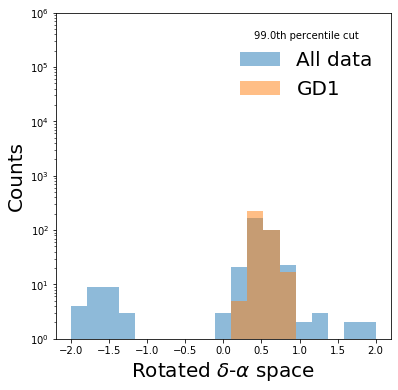

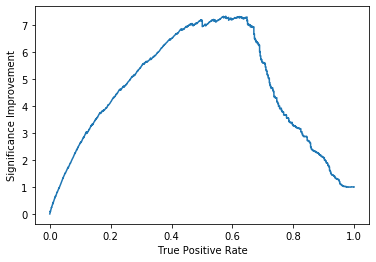

<Figure size 432x288 with 0 Axes>

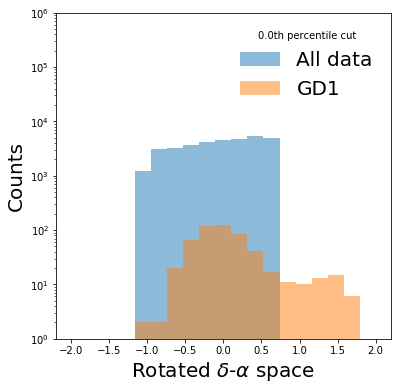

<Figure size 432x288 with 0 Axes>

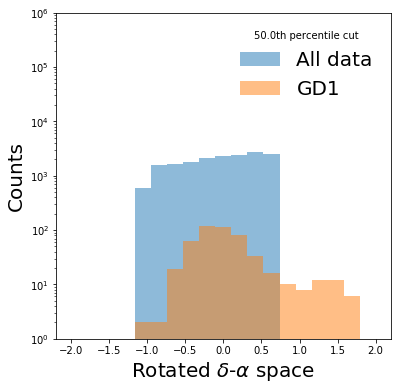

<Figure size 432x288 with 0 Axes>

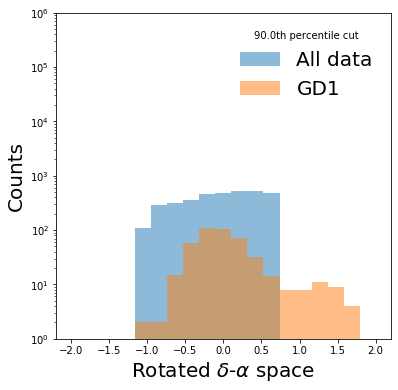

<Figure size 432x288 with 0 Axes>

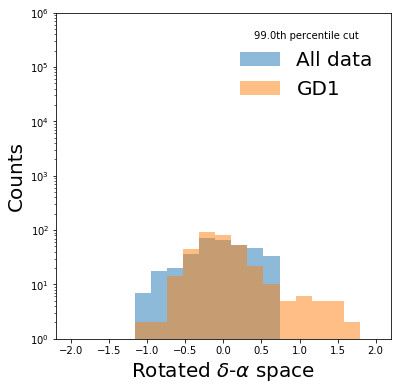







8



Train on 71263 samples, validate on 71264 samples
Epoch 1/20
71263/71263 [==============================] - 4s 61us/step - loss: 0.6938 - acc: 0.4993 - val_loss: 0.6932 - val_acc: 0.5043
Epoch 2/20
71263/71263 [==============================] - 3s 39us/step - loss: 0.6933 - acc: 0.5004 - val_loss: 0.6934 - val_acc: 0.5002
Epoch 3/20
71263/71263 [==============================] - 3s 39us/step - loss: 0.6932 - acc: 0.5040 - val_loss: 0.6931 - val_acc: 0.5059
Epoch 4/20
71263/71263 [==============================] - 3s 40us/step - loss: 0.6931 - acc: 0.5046 - val_loss: 0.6931 - val_acc: 0.5049
Epoch 5/20
71263/71263 [==============================] - 3s 40us/step - loss: 0.6930 - acc: 0.5052 - val_loss: 0.6930 - val_acc: 0.5028
Epoch 6/20
71263/71263 [==============================] - 3s 40us/step - loss: 0.6929 - acc: 0.5067 - val_loss: 0.6930 - val_acc: 0.5081
Epoch 7/20
71263/71263 [==============================] - 3s 38us/step - loss: 0.6928 - acc: 0.5056 - val_loss: 0.693

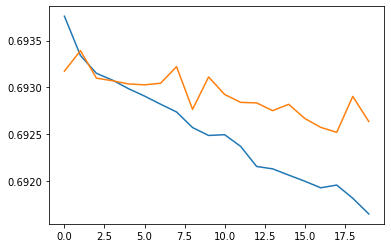

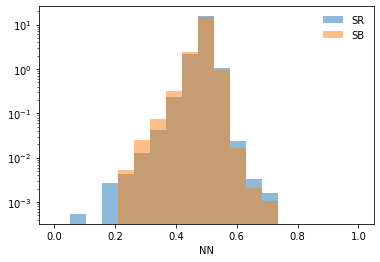

<Figure size 432x288 with 0 Axes>

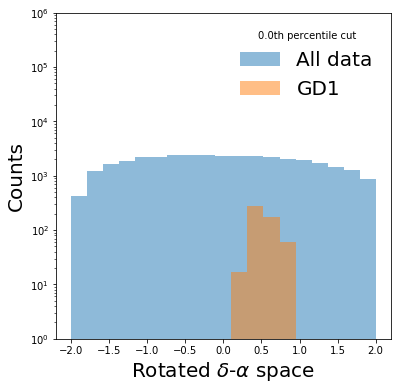

<Figure size 432x288 with 0 Axes>

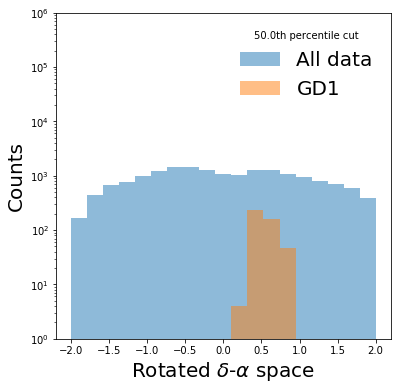

<Figure size 432x288 with 0 Axes>

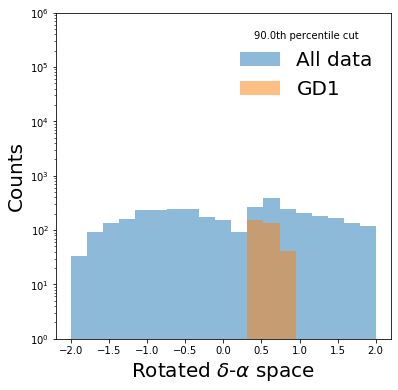

<Figure size 432x288 with 0 Axes>

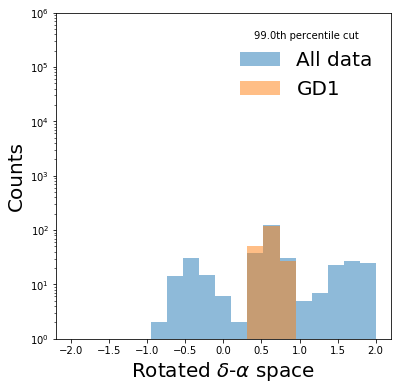

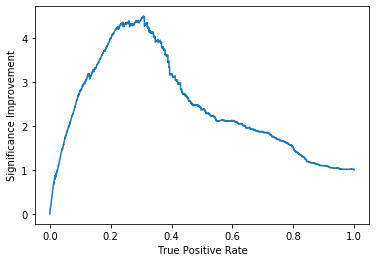

<Figure size 432x288 with 0 Axes>

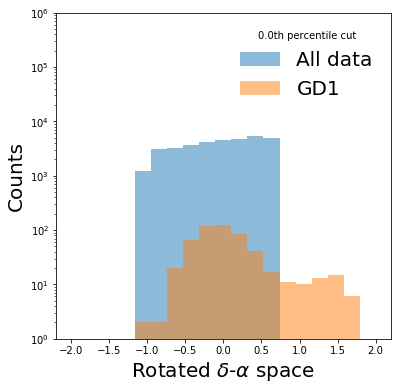

<Figure size 432x288 with 0 Axes>

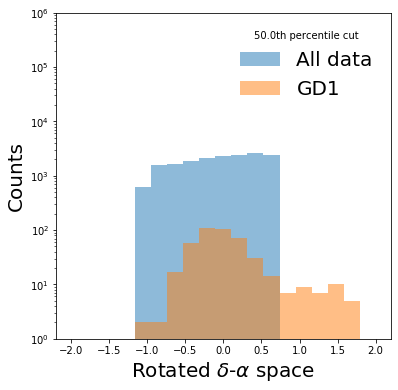

<Figure size 432x288 with 0 Axes>

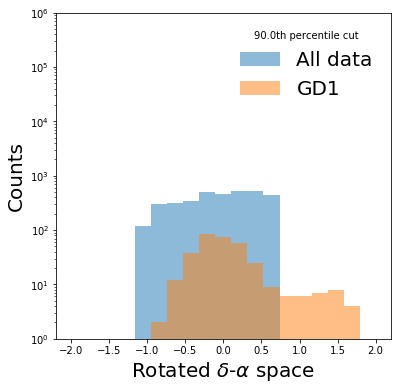

<Figure size 432x288 with 0 Axes>

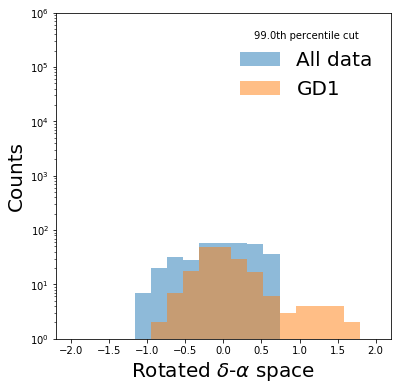







9



Train on 71263 samples, validate on 71264 samples
Epoch 1/20
71263/71263 [==============================] - 4s 63us/step - loss: 0.6937 - acc: 0.5031 - val_loss: 0.6936 - val_acc: 0.5053
Epoch 2/20
71263/71263 [==============================] - 3s 38us/step - loss: 0.6934 - acc: 0.4993 - val_loss: 0.6932 - val_acc: 0.4988
Epoch 3/20
71263/71263 [==============================] - 3s 40us/step - loss: 0.6932 - acc: 0.5035 - val_loss: 0.6931 - val_acc: 0.5029
Epoch 4/20
71263/71263 [==============================] - 3s 39us/step - loss: 0.6932 - acc: 0.5017 - val_loss: 0.6932 - val_acc: 0.4986
Epoch 5/20
71263/71263 [==============================] - 3s 40us/step - loss: 0.6931 - acc: 0.5035 - val_loss: 0.6929 - val_acc: 0.5083
Epoch 6/20
71263/71263 [==============================] - 3s 40us/step - loss: 0.6929 - acc: 0.5033 - val_loss: 0.6931 - val_acc: 0.5008
Epoch 7/20
71263/71263 [==============================] - 3s 41us/step - loss: 0.6929 - acc: 0.5058 - val_loss: 0.692

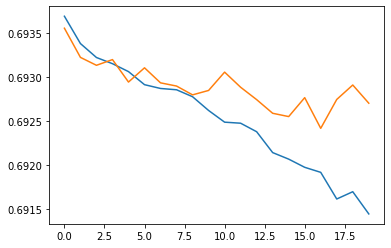

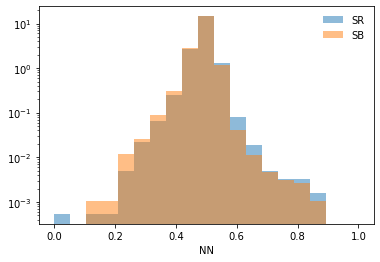

<Figure size 432x288 with 0 Axes>

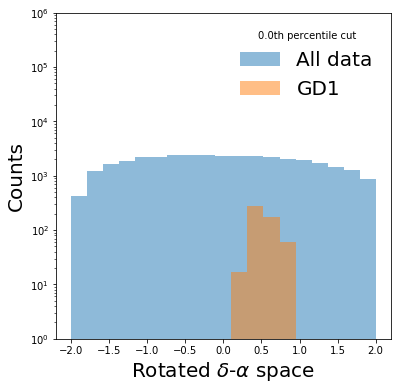

<Figure size 432x288 with 0 Axes>

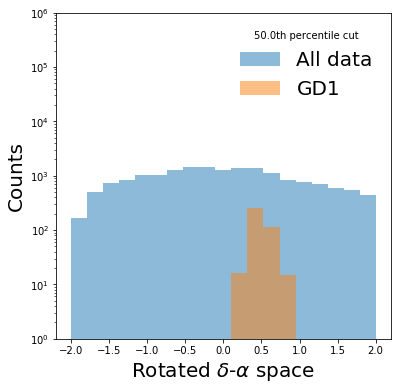

<Figure size 432x288 with 0 Axes>

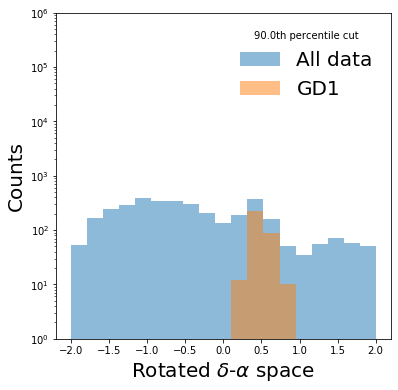

<Figure size 432x288 with 0 Axes>

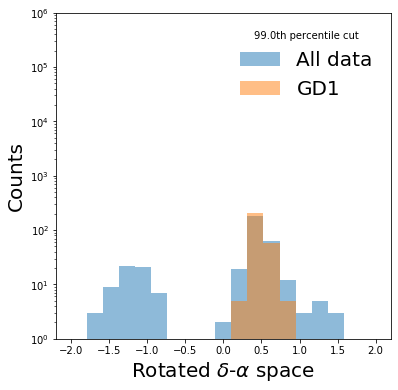

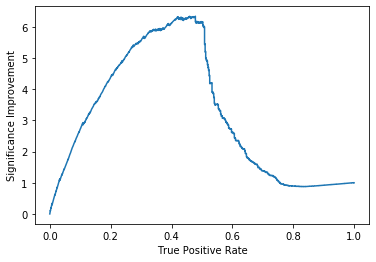

<Figure size 432x288 with 0 Axes>

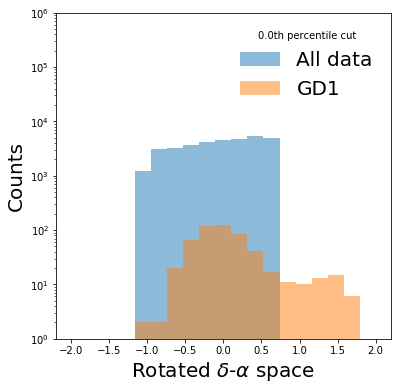

<Figure size 432x288 with 0 Axes>

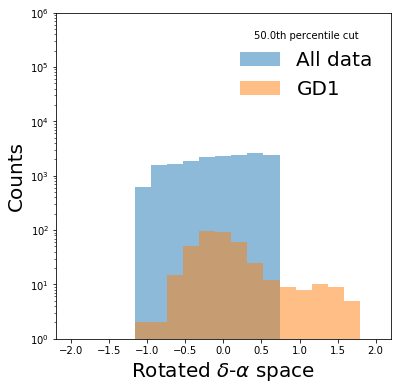

<Figure size 432x288 with 0 Axes>

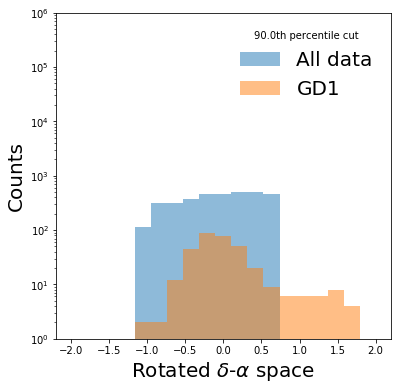

<Figure size 432x288 with 0 Axes>

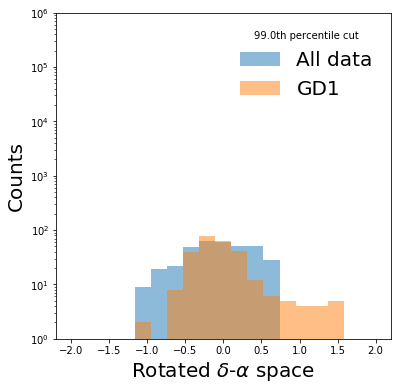







10



Train on 71263 samples, validate on 71264 samples
Epoch 1/20
71263/71263 [==============================] - 5s 63us/step - loss: 0.6937 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.5023
Epoch 2/20
71263/71263 [==============================] - 3s 41us/step - loss: 0.6933 - acc: 0.5010 - val_loss: 0.6937 - val_acc: 0.4969
Epoch 3/20
71263/71263 [==============================] - 3s 40us/step - loss: 0.6931 - acc: 0.5028 - val_loss: 0.6930 - val_acc: 0.5070
Epoch 4/20
71263/71263 [==============================] - 3s 40us/step - loss: 0.6930 - acc: 0.5042 - val_loss: 0.6930 - val_acc: 0.5047
Epoch 5/20
71263/71263 [==============================] - 3s 40us/step - loss: 0.6929 - acc: 0.5071 - val_loss: 0.6931 - val_acc: 0.5001
Epoch 6/20
71263/71263 [==============================] - 3s 38us/step - loss: 0.6927 - acc: 0.5094 - val_loss: 0.6929 - val_acc: 0.5060
Epoch 7/20
71263/71263 [==============================] - 3s 39us/step - loss: 0.6926 - acc: 0.5067 - val_loss: 0.69

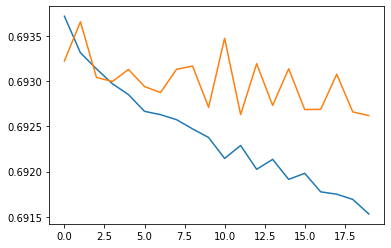

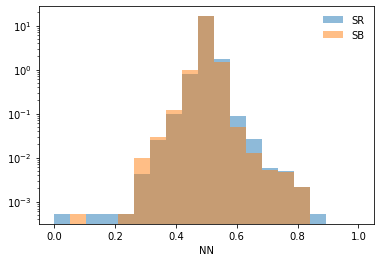

<Figure size 432x288 with 0 Axes>

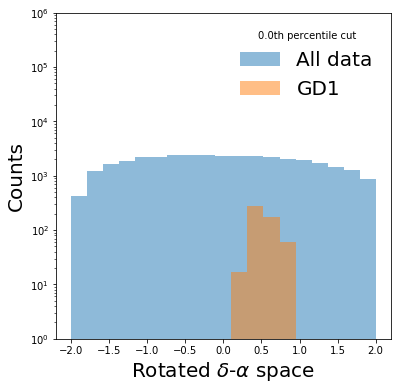

<Figure size 432x288 with 0 Axes>

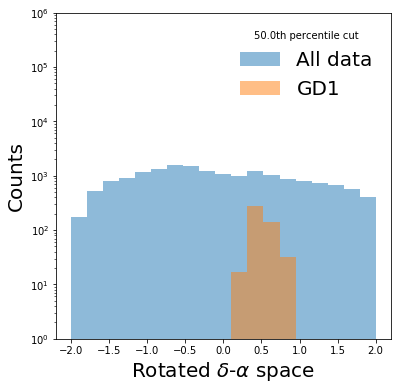

<Figure size 432x288 with 0 Axes>

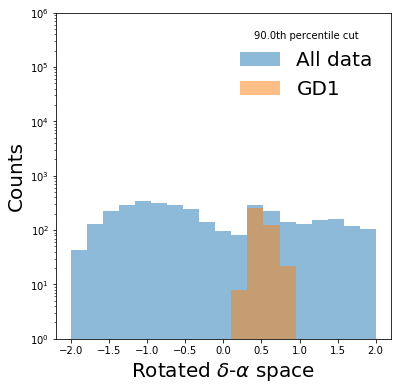

<Figure size 432x288 with 0 Axes>

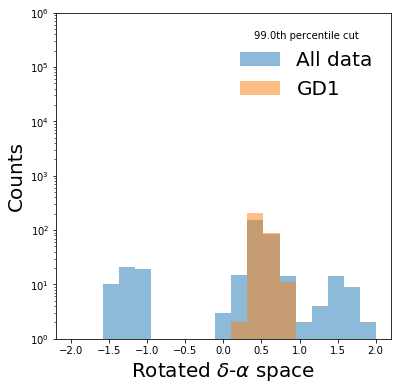

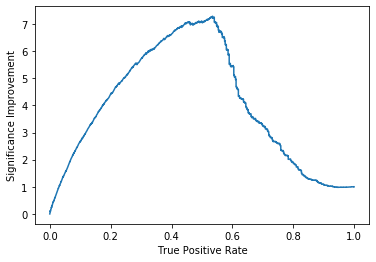

<Figure size 432x288 with 0 Axes>

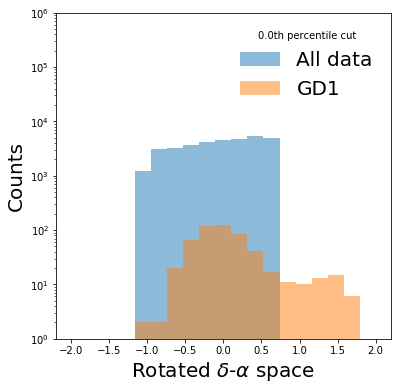

<Figure size 432x288 with 0 Axes>

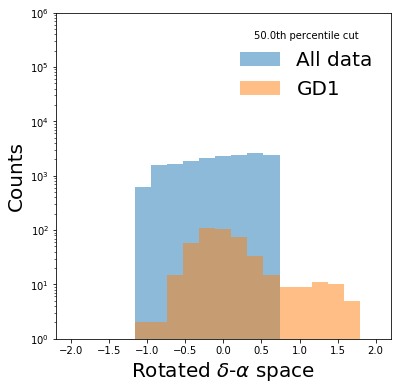

<Figure size 432x288 with 0 Axes>

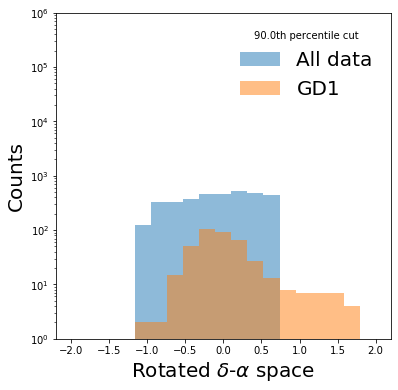

<Figure size 432x288 with 0 Axes>

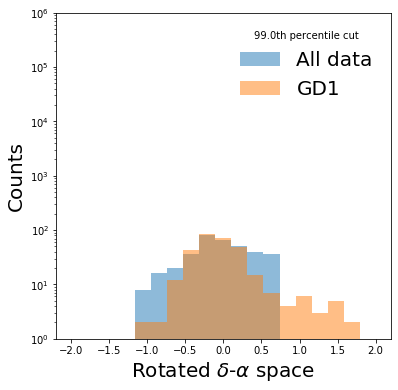







11



Train on 71263 samples, validate on 71264 samples
Epoch 1/20
71263/71263 [==============================] - 5s 66us/step - loss: 0.6936 - acc: 0.5002 - val_loss: 0.6932 - val_acc: 0.5022
Epoch 2/20
71263/71263 [==============================] - 3s 40us/step - loss: 0.6932 - acc: 0.5039 - val_loss: 0.6930 - val_acc: 0.5057
Epoch 3/20
71263/71263 [==============================] - 3s 40us/step - loss: 0.6932 - acc: 0.5031 - val_loss: 0.6932 - val_acc: 0.5011
Epoch 4/20
71263/71263 [==============================] - 3s 39us/step - loss: 0.6931 - acc: 0.5049 - val_loss: 0.6932 - val_acc: 0.5045
Epoch 5/20
71263/71263 [==============================] - 3s 40us/step - loss: 0.6929 - acc: 0.5071 - val_loss: 0.6930 - val_acc: 0.5083
Epoch 6/20
71263/71263 [==============================] - 3s 41us/step - loss: 0.6930 - acc: 0.5040 - val_loss: 0.6929 - val_acc: 0.5083
Epoch 7/20
71263/71263 [==============================] - 3s 39us/step - loss: 0.6928 - acc: 0.5066 - val_loss: 0.69

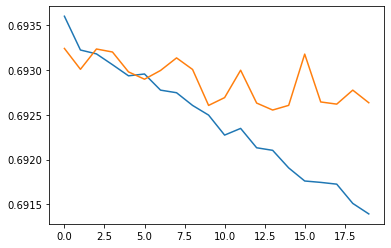

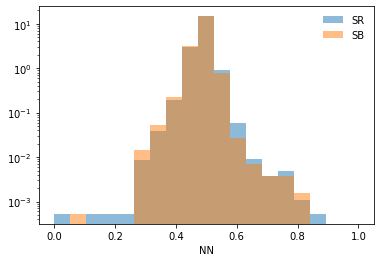

<Figure size 432x288 with 0 Axes>

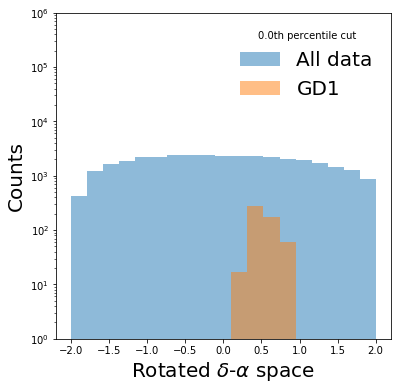

<Figure size 432x288 with 0 Axes>

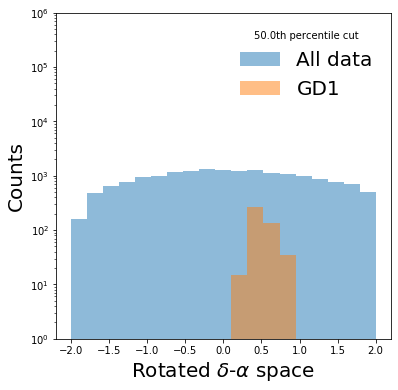

<Figure size 432x288 with 0 Axes>

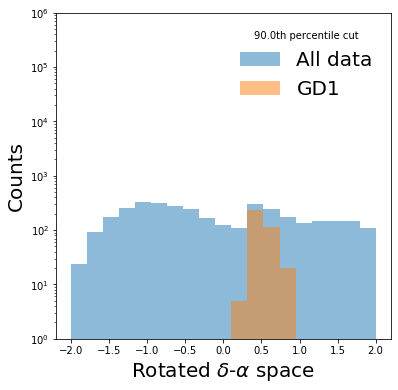

<Figure size 432x288 with 0 Axes>

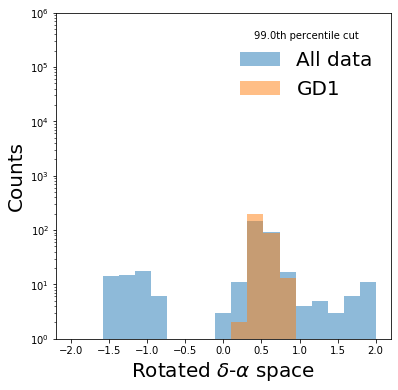

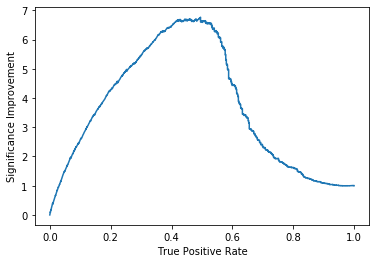

<Figure size 432x288 with 0 Axes>

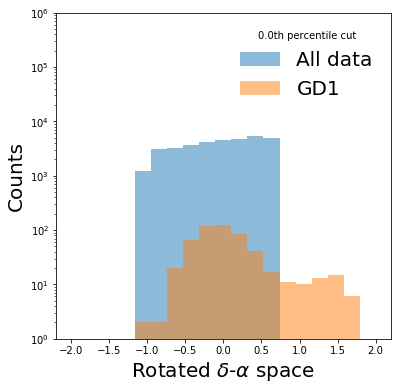

<Figure size 432x288 with 0 Axes>

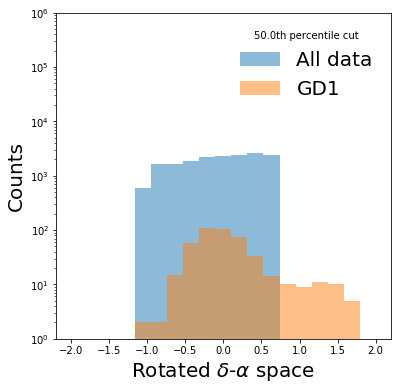

<Figure size 432x288 with 0 Axes>

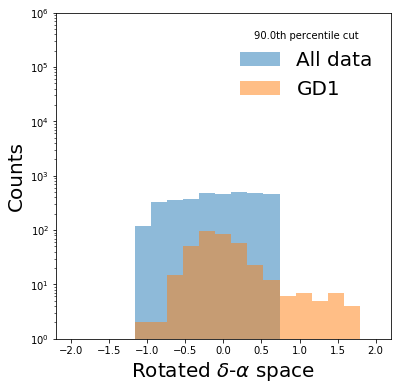

<Figure size 432x288 with 0 Axes>

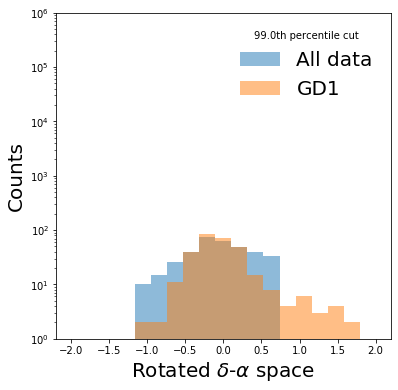







12



Train on 71263 samples, validate on 71264 samples
Epoch 1/20
71263/71263 [==============================] - 5s 67us/step - loss: 0.6937 - acc: 0.5006 - val_loss: 0.6933 - val_acc: 0.5044
Epoch 2/20
71263/71263 [==============================] - 3s 41us/step - loss: 0.6933 - acc: 0.5023 - val_loss: 0.6932 - val_acc: 0.5003
Epoch 3/20
71263/71263 [==============================] - 3s 39us/step - loss: 0.6932 - acc: 0.5025 - val_loss: 0.6932 - val_acc: 0.5033
Epoch 4/20
71263/71263 [==============================] - 3s 39us/step - loss: 0.6931 - acc: 0.5057 - val_loss: 0.6931 - val_acc: 0.5018
Epoch 5/20
71263/71263 [==============================] - 3s 41us/step - loss: 0.6931 - acc: 0.5030 - val_loss: 0.6929 - val_acc: 0.5068
Epoch 6/20
71263/71263 [==============================] - 3s 41us/step - loss: 0.6930 - acc: 0.5045 - val_loss: 0.6929 - val_acc: 0.5051
Epoch 7/20
71263/71263 [==============================] - 3s 39us/step - loss: 0.6929 - acc: 0.5051 - val_loss: 0.69

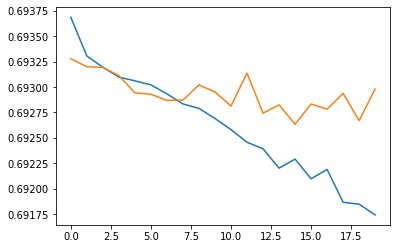

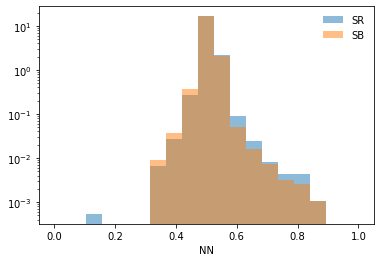

<Figure size 432x288 with 0 Axes>

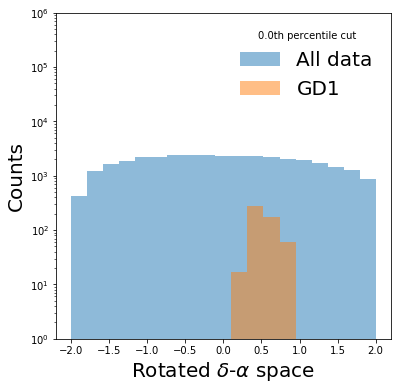

<Figure size 432x288 with 0 Axes>

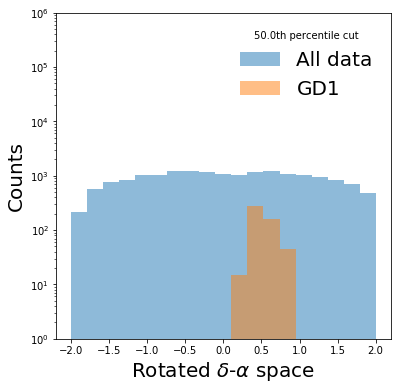

<Figure size 432x288 with 0 Axes>

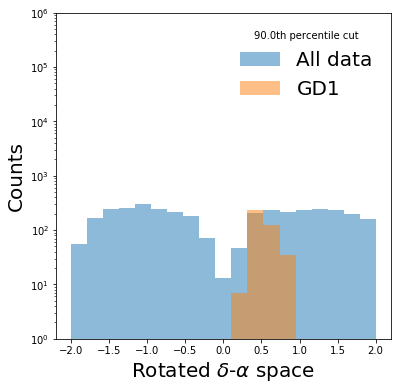

<Figure size 432x288 with 0 Axes>

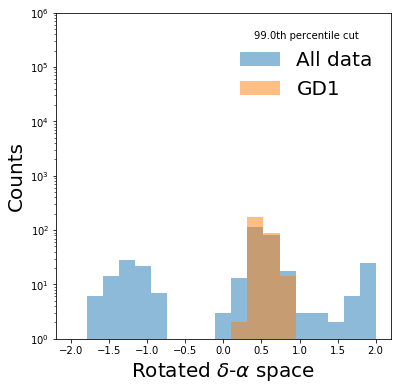

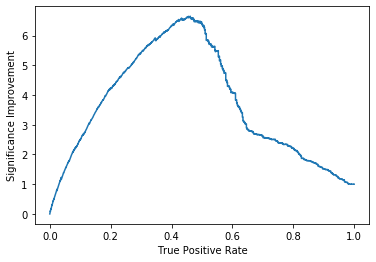

<Figure size 432x288 with 0 Axes>

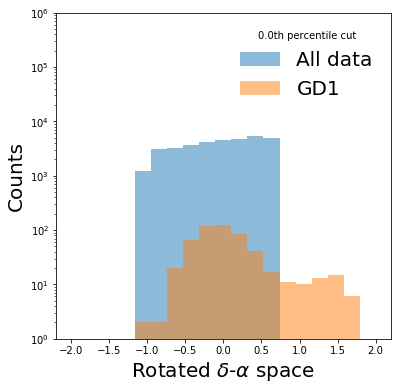

<Figure size 432x288 with 0 Axes>

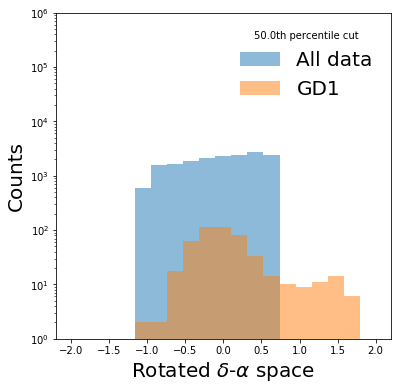

<Figure size 432x288 with 0 Axes>

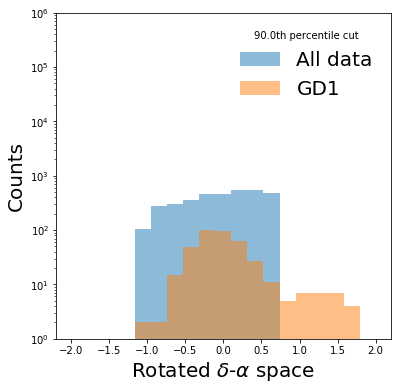

<Figure size 432x288 with 0 Axes>

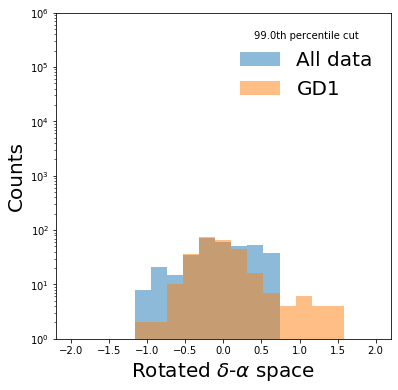







13



Train on 71263 samples, validate on 71264 samples
Epoch 1/20
71263/71263 [==============================] - 5s 70us/step - loss: 0.6937 - acc: 0.5001 - val_loss: 0.6932 - val_acc: 0.5059
Epoch 2/20
71263/71263 [==============================] - 3s 40us/step - loss: 0.6933 - acc: 0.5013 - val_loss: 0.6934 - val_acc: 0.5017
Epoch 3/20
71263/71263 [==============================] - 3s 41us/step - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6932 - val_acc: 0.4998
Epoch 4/20
71263/71263 [==============================] - 3s 40us/step - loss: 0.6932 - acc: 0.5022 - val_loss: 0.6931 - val_acc: 0.4981
Epoch 5/20
71263/71263 [==============================] - 3s 39us/step - loss: 0.6930 - acc: 0.5063 - val_loss: 0.6930 - val_acc: 0.5045
Epoch 6/20
71263/71263 [==============================] - 3s 41us/step - loss: 0.6929 - acc: 0.5058 - val_loss: 0.6930 - val_acc: 0.5079
Epoch 7/20
71263/71263 [==============================] - 3s 39us/step - loss: 0.6928 - acc: 0.5081 - val_loss: 0.69

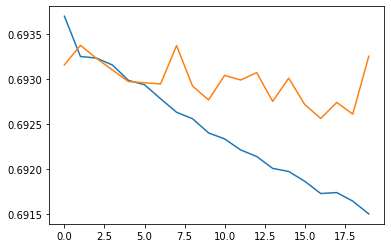

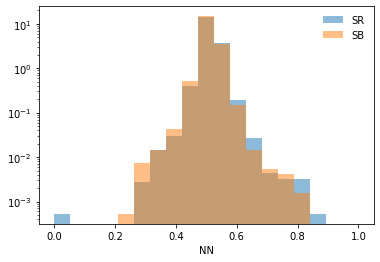

<Figure size 432x288 with 0 Axes>

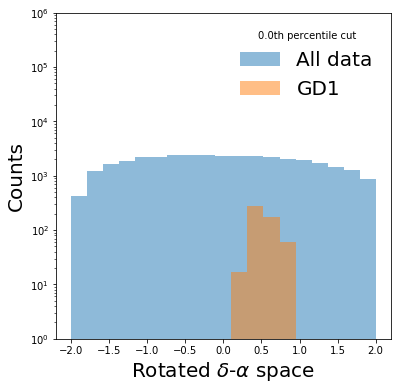

<Figure size 432x288 with 0 Axes>

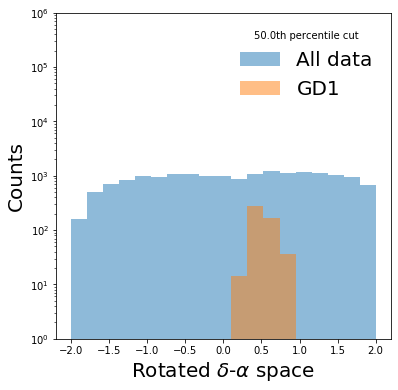

<Figure size 432x288 with 0 Axes>

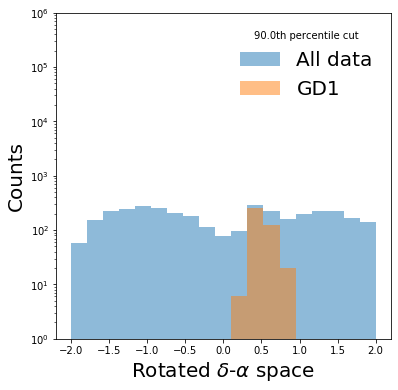

<Figure size 432x288 with 0 Axes>

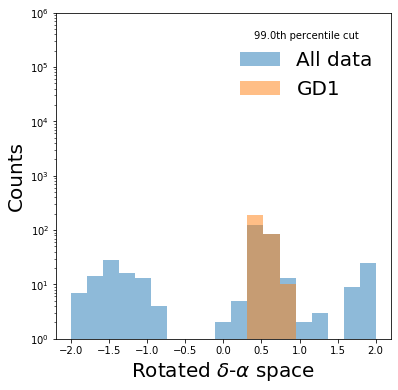

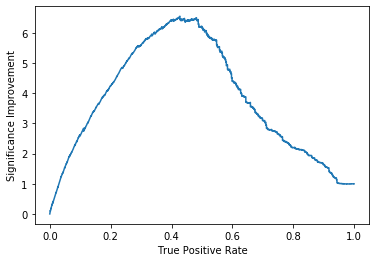

<Figure size 432x288 with 0 Axes>

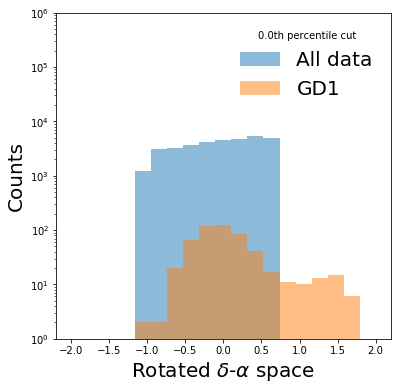

<Figure size 432x288 with 0 Axes>

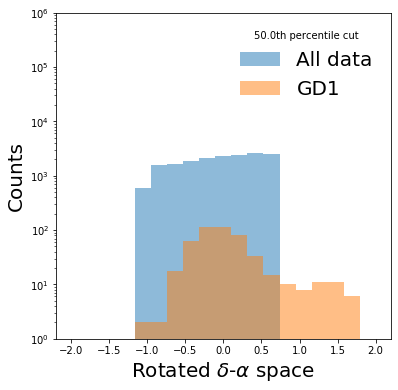

<Figure size 432x288 with 0 Axes>

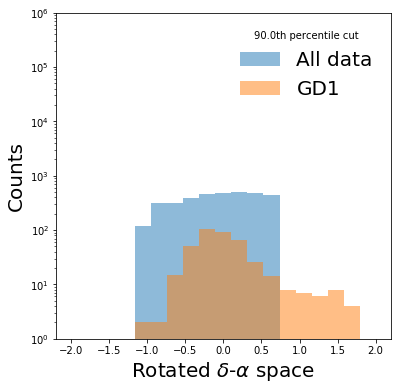

<Figure size 432x288 with 0 Axes>

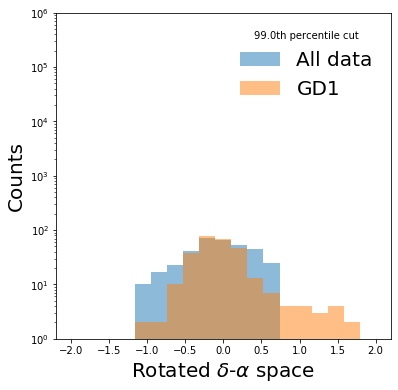







14



Train on 71263 samples, validate on 71264 samples
Epoch 1/20
71263/71263 [==============================] - 5s 69us/step - loss: 0.6937 - acc: 0.4993 - val_loss: 0.6932 - val_acc: 0.4995
Epoch 2/20
71263/71263 [==============================] - 3s 41us/step - loss: 0.6933 - acc: 0.4997 - val_loss: 0.6931 - val_acc: 0.5052
Epoch 3/20
71263/71263 [==============================] - 3s 41us/step - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6932 - val_acc: 0.5030
Epoch 4/20
71263/71263 [==============================] - 3s 39us/step - loss: 0.6931 - acc: 0.5016 - val_loss: 0.6932 - val_acc: 0.5060
Epoch 5/20
71263/71263 [==============================] - 3s 41us/step - loss: 0.6930 - acc: 0.5044 - val_loss: 0.6935 - val_acc: 0.4989
Epoch 6/20
71263/71263 [==============================] - 3s 42us/step - loss: 0.6931 - acc: 0.5045 - val_loss: 0.6931 - val_acc: 0.5054
Epoch 7/20
71263/71263 [==============================] - 3s 41us/step - loss: 0.6930 - acc: 0.5057 - val_loss: 0.69

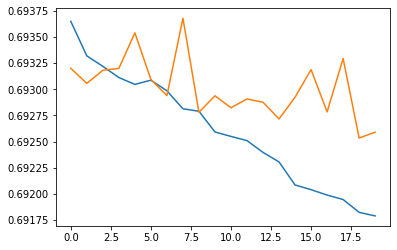

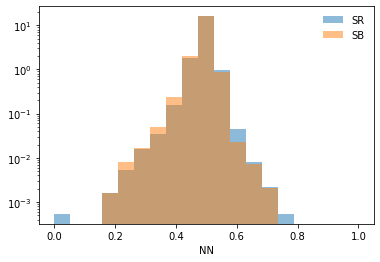

<Figure size 432x288 with 0 Axes>

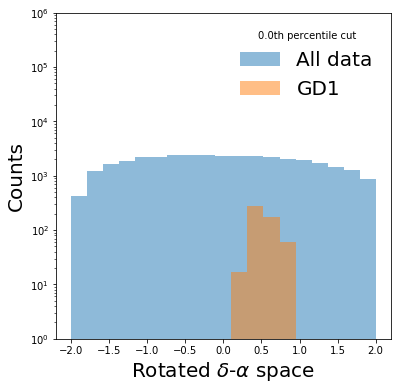

<Figure size 432x288 with 0 Axes>

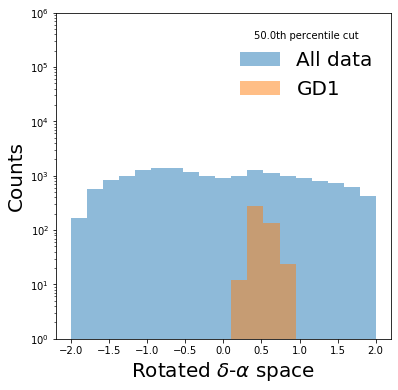

<Figure size 432x288 with 0 Axes>

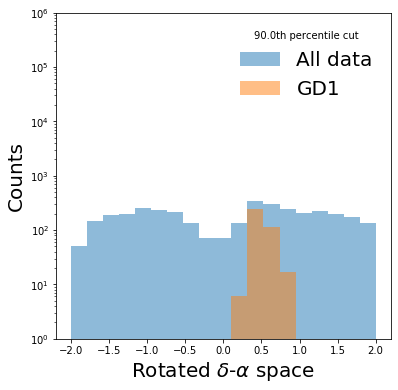

<Figure size 432x288 with 0 Axes>

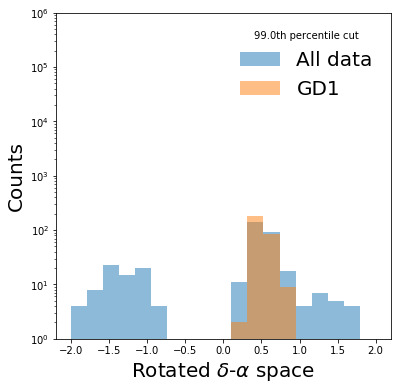

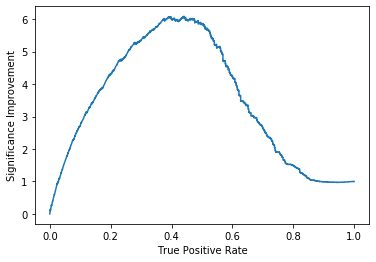

<Figure size 432x288 with 0 Axes>

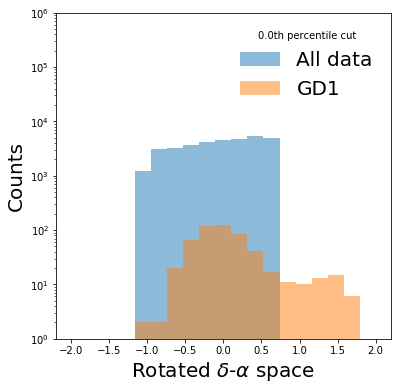

<Figure size 432x288 with 0 Axes>

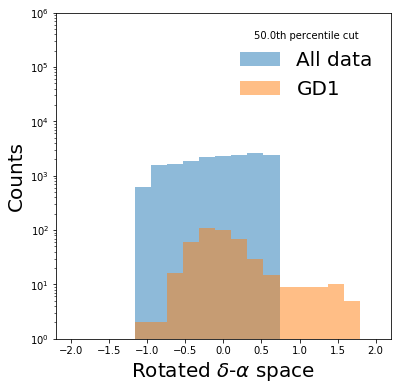

<Figure size 432x288 with 0 Axes>

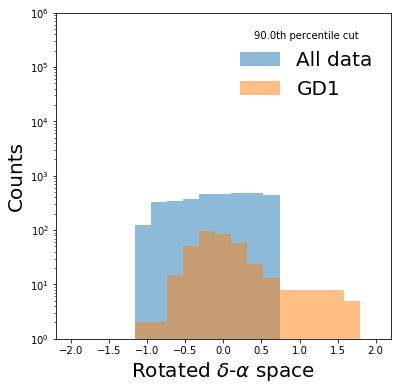

<Figure size 432x288 with 0 Axes>

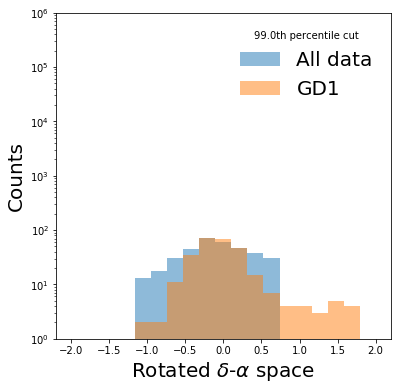







15



Train on 71263 samples, validate on 71264 samples
Epoch 1/20
71263/71263 [==============================] - 5s 69us/step - loss: 0.6938 - acc: 0.4974 - val_loss: 0.6930 - val_acc: 0.5055
Epoch 2/20
71263/71263 [==============================] - 3s 41us/step - loss: 0.6933 - acc: 0.5007 - val_loss: 0.6931 - val_acc: 0.5049
Epoch 3/20
71263/71263 [==============================] - 3s 40us/step - loss: 0.6932 - acc: 0.5032 - val_loss: 0.6930 - val_acc: 0.5059
Epoch 4/20
71263/71263 [==============================] - 3s 41us/step - loss: 0.6931 - acc: 0.5043 - val_loss: 0.6931 - val_acc: 0.5017
Epoch 5/20
71263/71263 [==============================] - 3s 41us/step - loss: 0.6930 - acc: 0.5066 - val_loss: 0.6929 - val_acc: 0.5086
Epoch 6/20
71263/71263 [==============================] - 3s 40us/step - loss: 0.6929 - acc: 0.5087 - val_loss: 0.6930 - val_acc: 0.5015
Epoch 7/20
71263/71263 [==============================] - 3s 41us/step - loss: 0.6929 - acc: 0.5074 - val_loss: 0.69

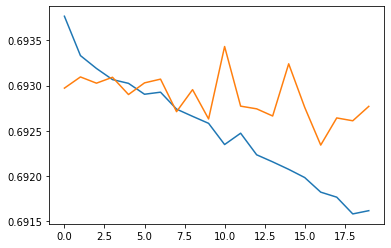

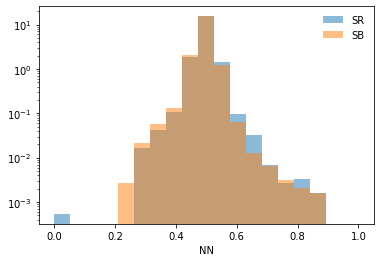

<Figure size 432x288 with 0 Axes>

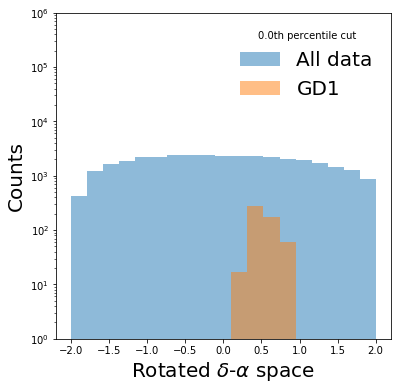

<Figure size 432x288 with 0 Axes>

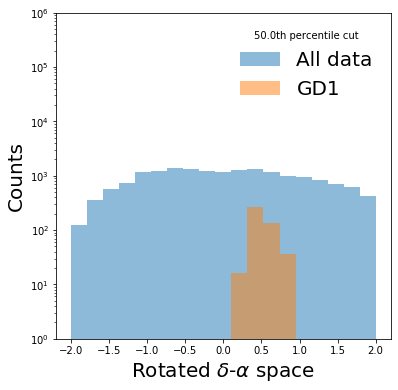

<Figure size 432x288 with 0 Axes>

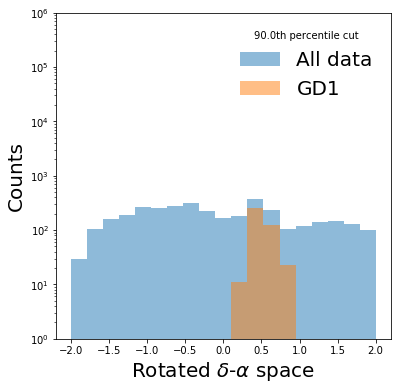

<Figure size 432x288 with 0 Axes>

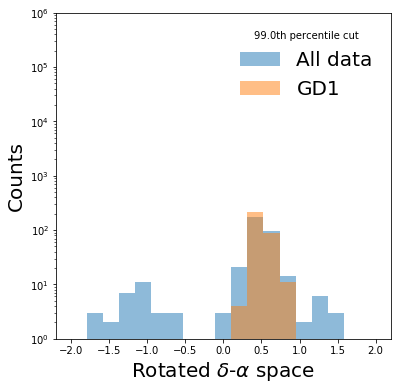

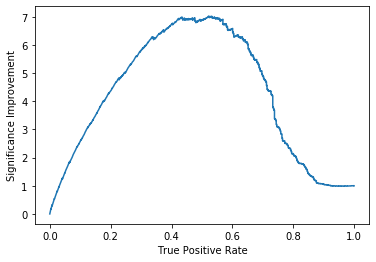

<Figure size 432x288 with 0 Axes>

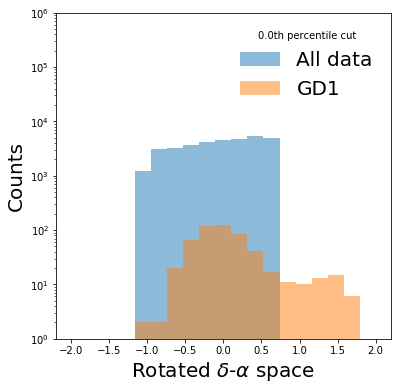

<Figure size 432x288 with 0 Axes>

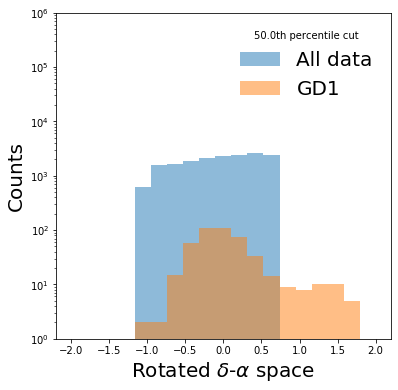

<Figure size 432x288 with 0 Axes>

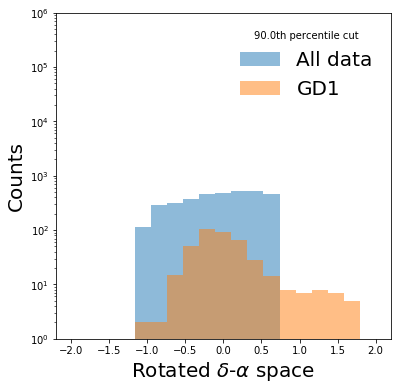

<Figure size 432x288 with 0 Axes>

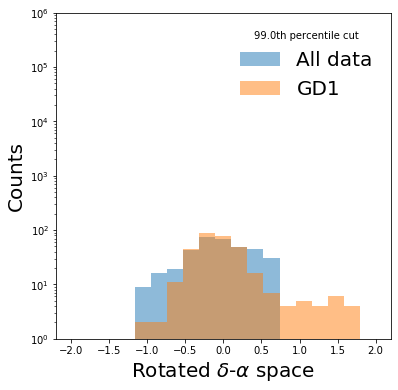







16



Train on 71263 samples, validate on 71264 samples
Epoch 1/20
71263/71263 [==============================] - 5s 73us/step - loss: 0.6937 - acc: 0.4982 - val_loss: 0.6935 - val_acc: 0.4967
Epoch 2/20
71263/71263 [==============================] - 3s 42us/step - loss: 0.6934 - acc: 0.4990 - val_loss: 0.6936 - val_acc: 0.4962
Epoch 3/20
71263/71263 [==============================] - 3s 41us/step - loss: 0.6932 - acc: 0.5014 - val_loss: 0.6932 - val_acc: 0.4983
Epoch 4/20
71263/71263 [==============================] - 3s 42us/step - loss: 0.6931 - acc: 0.5027 - val_loss: 0.6930 - val_acc: 0.5079
Epoch 5/20
71263/71263 [==============================] - 3s 42us/step - loss: 0.6931 - acc: 0.5039 - val_loss: 0.6932 - val_acc: 0.4977
Epoch 6/20
71263/71263 [==============================] - 3s 41us/step - loss: 0.6929 - acc: 0.5070 - val_loss: 0.6930 - val_acc: 0.5056
Epoch 7/20
71263/71263 [==============================] - 3s 41us/step - loss: 0.6929 - acc: 0.5063 - val_loss: 0.69

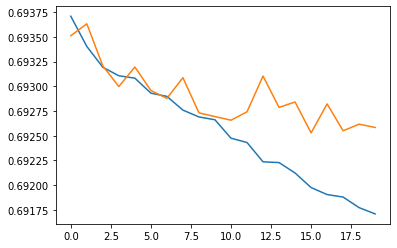

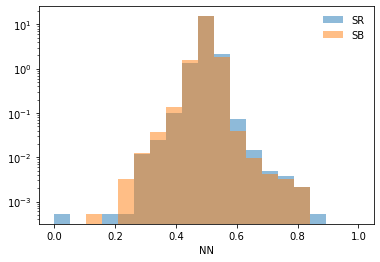

<Figure size 432x288 with 0 Axes>

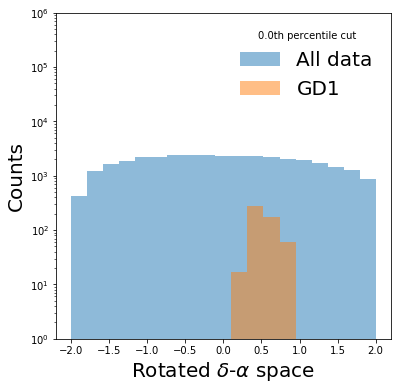

<Figure size 432x288 with 0 Axes>

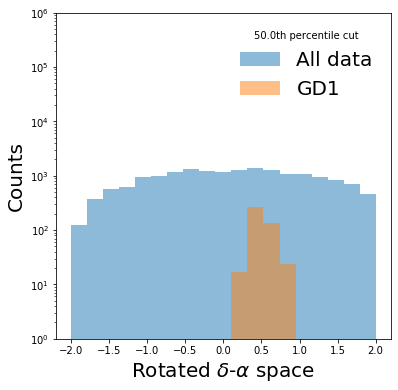

<Figure size 432x288 with 0 Axes>

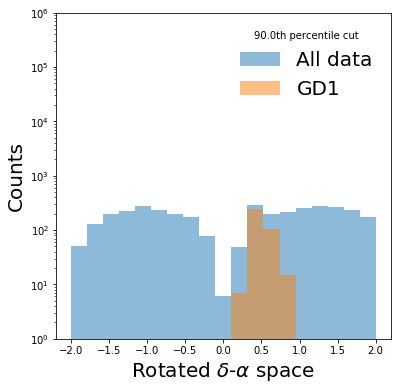

<Figure size 432x288 with 0 Axes>

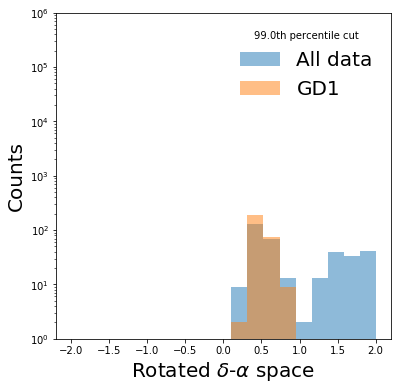

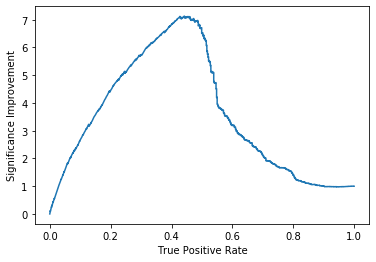

<Figure size 432x288 with 0 Axes>

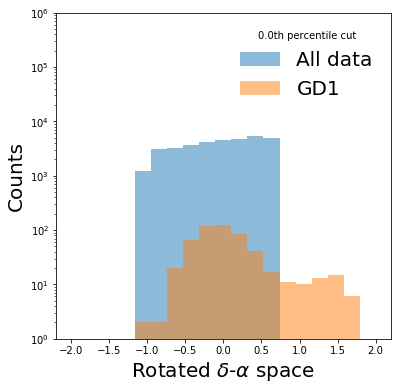

<Figure size 432x288 with 0 Axes>

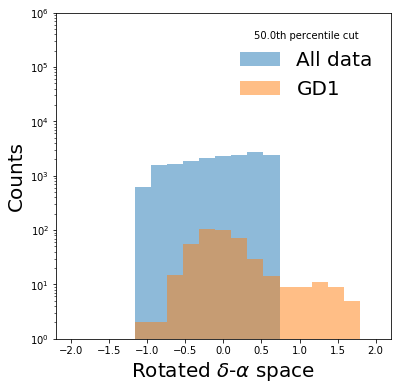

<Figure size 432x288 with 0 Axes>

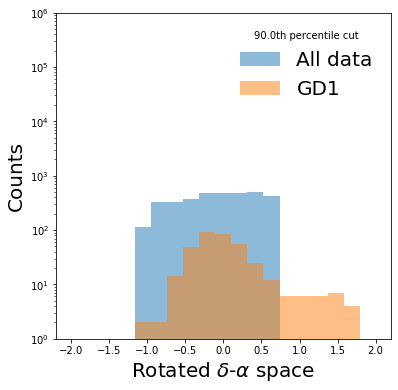

<Figure size 432x288 with 0 Axes>

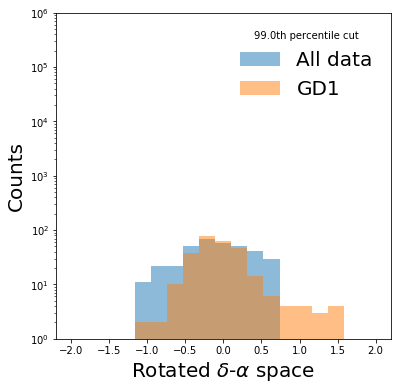







17



Train on 71263 samples, validate on 71264 samples
Epoch 1/20
71263/71263 [==============================] - 5s 73us/step - loss: 0.6940 - acc: 0.4964 - val_loss: 0.6932 - val_acc: 0.5001
Epoch 2/20
71263/71263 [==============================] - 3s 42us/step - loss: 0.6934 - acc: 0.5010 - val_loss: 0.6933 - val_acc: 0.5016
Epoch 3/20
71263/71263 [==============================] - 3s 42us/step - loss: 0.6932 - acc: 0.5024 - val_loss: 0.6930 - val_acc: 0.5039
Epoch 4/20
71263/71263 [==============================] - 3s 42us/step - loss: 0.6932 - acc: 0.5013 - val_loss: 0.6933 - val_acc: 0.4983
Epoch 5/20
71263/71263 [==============================] - 3s 41us/step - loss: 0.6932 - acc: 0.5015 - val_loss: 0.6933 - val_acc: 0.4974
Epoch 6/20
71263/71263 [==============================] - 3s 42us/step - loss: 0.6931 - acc: 0.5044 - val_loss: 0.6931 - val_acc: 0.5033
Epoch 7/20
71263/71263 [==============================] - 3s 41us/step - loss: 0.6930 - acc: 0.5080 - val_loss: 0.69

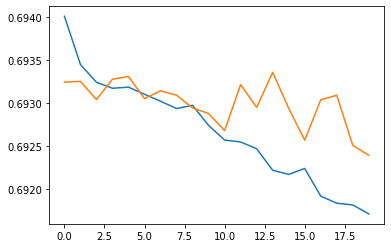

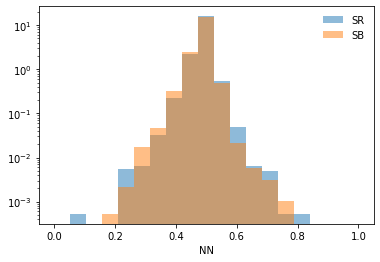

<Figure size 432x288 with 0 Axes>

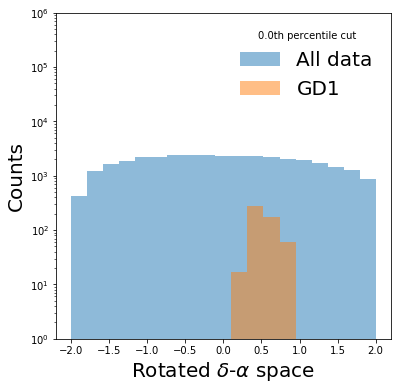

<Figure size 432x288 with 0 Axes>

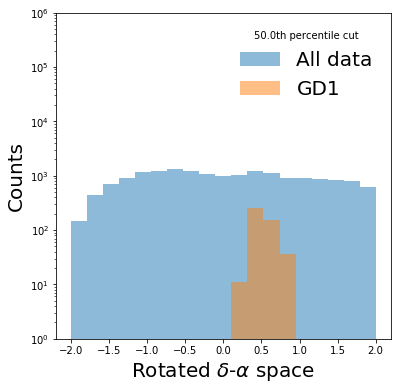

<Figure size 432x288 with 0 Axes>

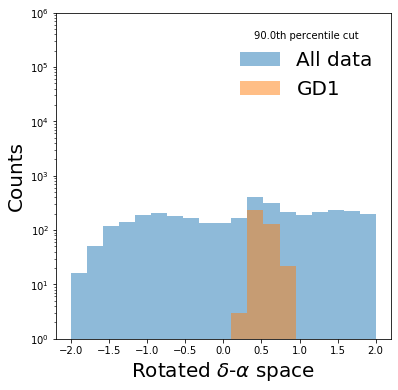

<Figure size 432x288 with 0 Axes>

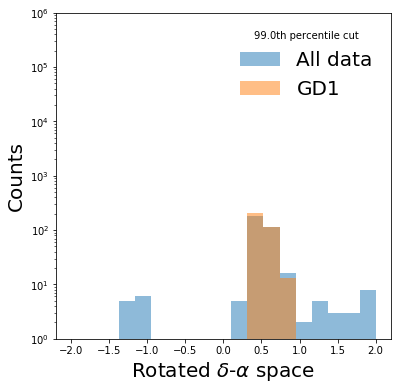

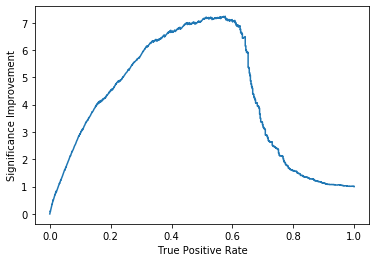

<Figure size 432x288 with 0 Axes>

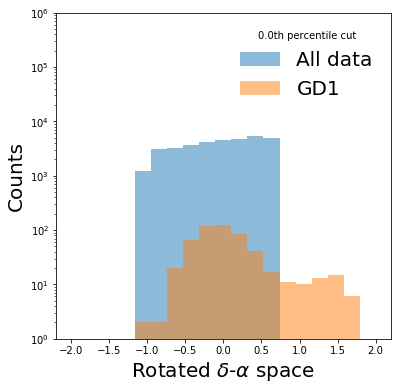

<Figure size 432x288 with 0 Axes>

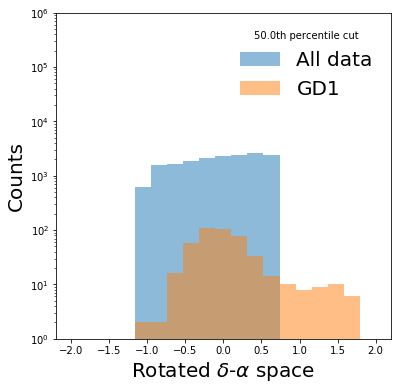

<Figure size 432x288 with 0 Axes>

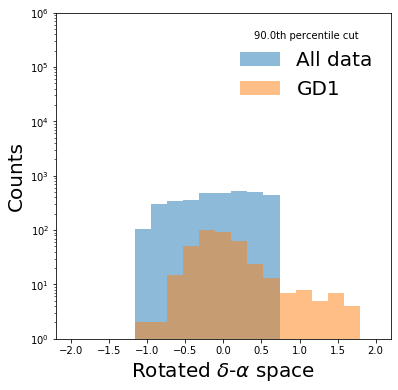

<Figure size 432x288 with 0 Axes>

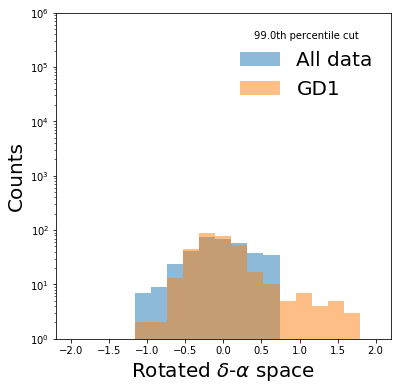







18



Train on 71263 samples, validate on 71264 samples
Epoch 1/20
71263/71263 [==============================] - 6s 78us/step - loss: 0.6937 - acc: 0.4978 - val_loss: 0.6932 - val_acc: 0.5026
Epoch 2/20
71263/71263 [==============================] - 3s 39us/step - loss: 0.6933 - acc: 0.5019 - val_loss: 0.6933 - val_acc: 0.4982
Epoch 3/20
71263/71263 [==============================] - 3s 42us/step - loss: 0.6933 - acc: 0.5008 - val_loss: 0.6931 - val_acc: 0.5063
Epoch 4/20
71263/71263 [==============================] - 3s 42us/step - loss: 0.6931 - acc: 0.5030 - val_loss: 0.6932 - val_acc: 0.5026
Epoch 5/20
71263/71263 [==============================] - 3s 42us/step - loss: 0.6931 - acc: 0.5055 - val_loss: 0.6931 - val_acc: 0.5061
Epoch 6/20
71263/71263 [==============================] - 3s 42us/step - loss: 0.6930 - acc: 0.5056 - val_loss: 0.6930 - val_acc: 0.5072
Epoch 7/20
71263/71263 [==============================] - 3s 42us/step - loss: 0.6930 - acc: 0.5068 - val_loss: 0.69

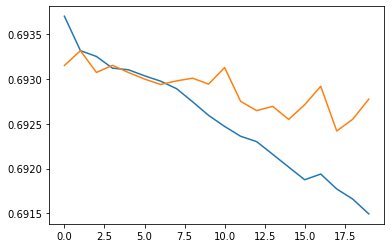

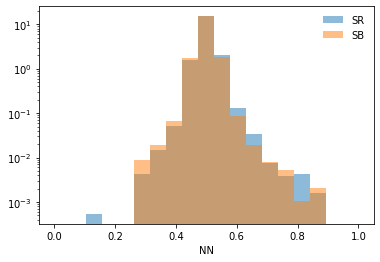

<Figure size 432x288 with 0 Axes>

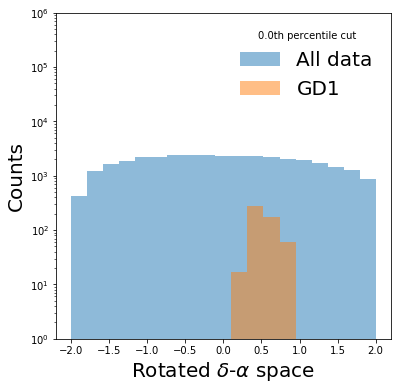

<Figure size 432x288 with 0 Axes>

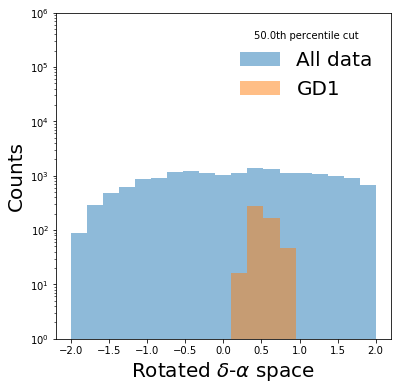

<Figure size 432x288 with 0 Axes>

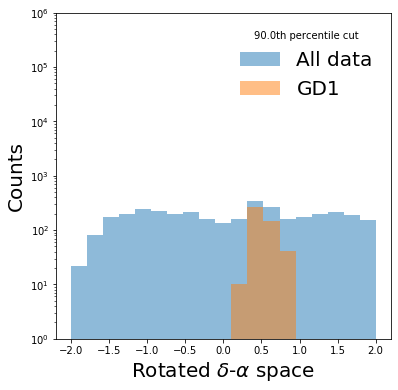

<Figure size 432x288 with 0 Axes>

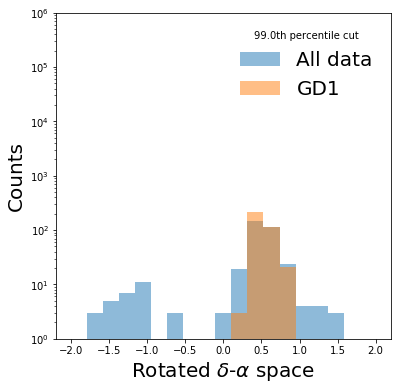

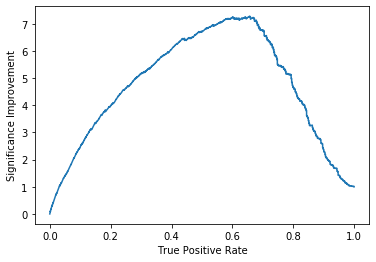

<Figure size 432x288 with 0 Axes>

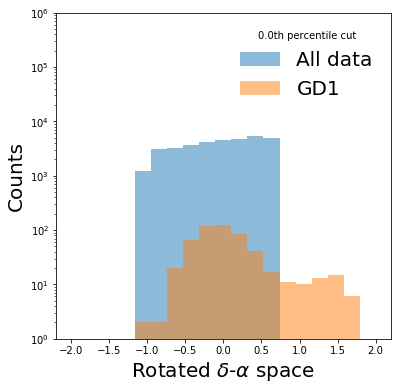

<Figure size 432x288 with 0 Axes>

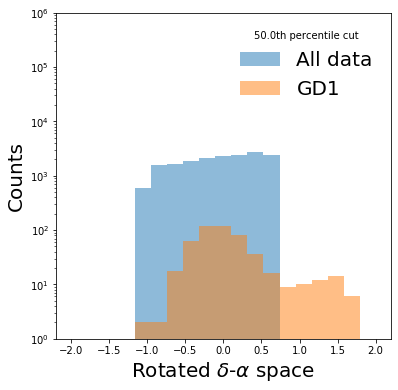

<Figure size 432x288 with 0 Axes>

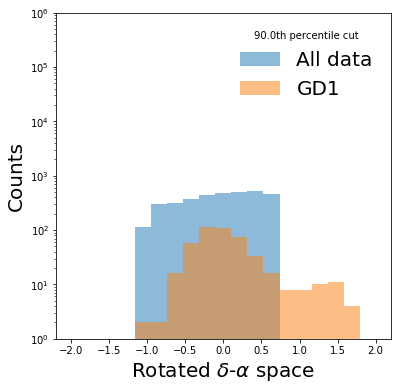

<Figure size 432x288 with 0 Axes>

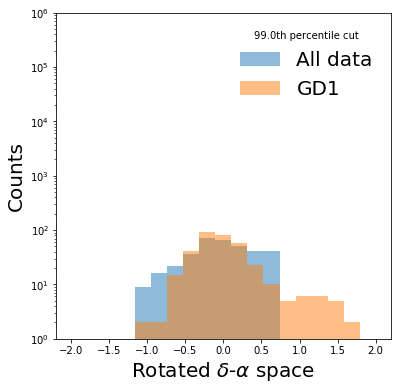







19



Train on 71263 samples, validate on 71264 samples
Epoch 1/20
71263/71263 [==============================] - 5s 75us/step - loss: 0.6935 - acc: 0.5028 - val_loss: 0.6934 - val_acc: 0.5030
Epoch 2/20
71263/71263 [==============================] - 3s 43us/step - loss: 0.6933 - acc: 0.5022 - val_loss: 0.6931 - val_acc: 0.5072
Epoch 3/20
71263/71263 [==============================] - 3s 43us/step - loss: 0.6932 - acc: 0.5021 - val_loss: 0.6929 - val_acc: 0.5084
Epoch 4/20
71263/71263 [==============================] - 3s 43us/step - loss: 0.6930 - acc: 0.5057 - val_loss: 0.6932 - val_acc: 0.5068
Epoch 5/20
71263/71263 [==============================] - 3s 42us/step - loss: 0.6931 - acc: 0.5054 - val_loss: 0.6929 - val_acc: 0.5059
Epoch 6/20
71263/71263 [==============================] - 3s 42us/step - loss: 0.6930 - acc: 0.5047 - val_loss: 0.6930 - val_acc: 0.5039
Epoch 7/20
71263/71263 [==============================] - 3s 42us/step - loss: 0.6929 - acc: 0.5104 - val_loss: 0.69

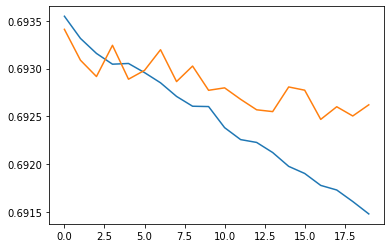

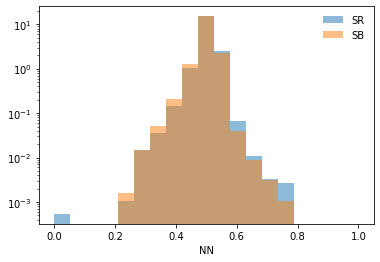

<Figure size 432x288 with 0 Axes>

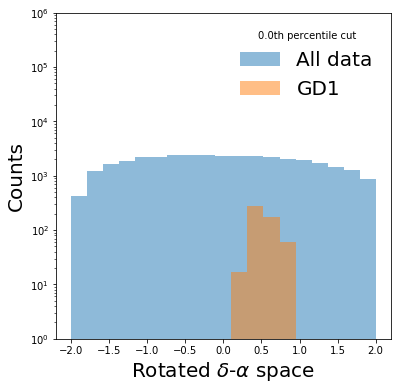

<Figure size 432x288 with 0 Axes>

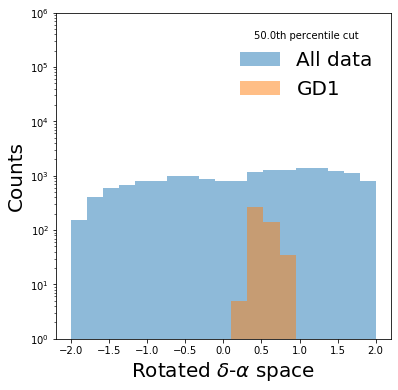

<Figure size 432x288 with 0 Axes>

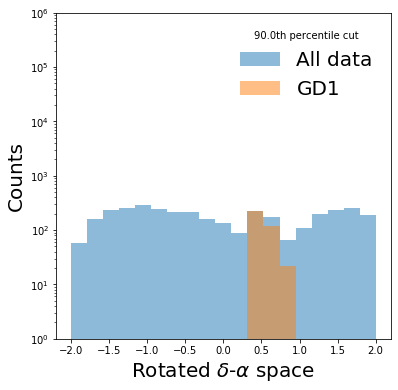

<Figure size 432x288 with 0 Axes>

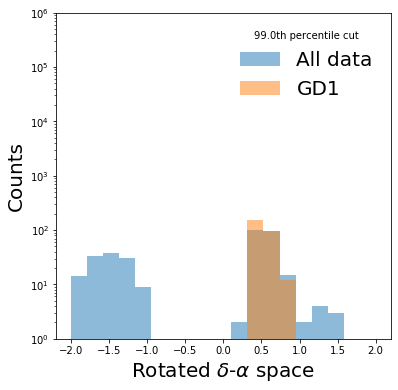

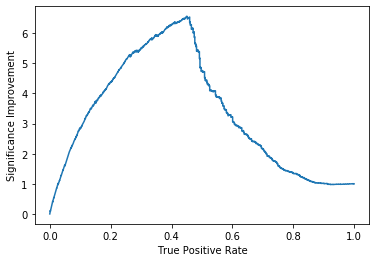

<Figure size 432x288 with 0 Axes>

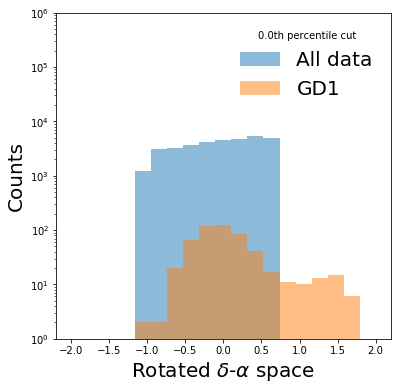

<Figure size 432x288 with 0 Axes>

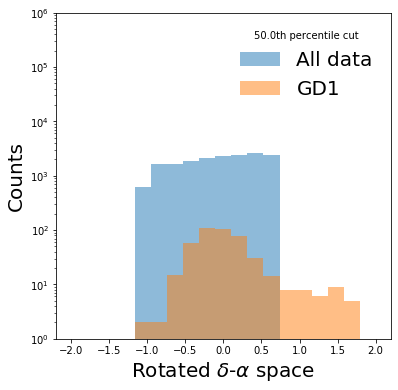

<Figure size 432x288 with 0 Axes>

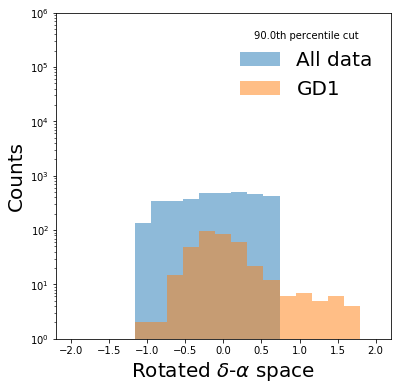

<Figure size 432x288 with 0 Axes>

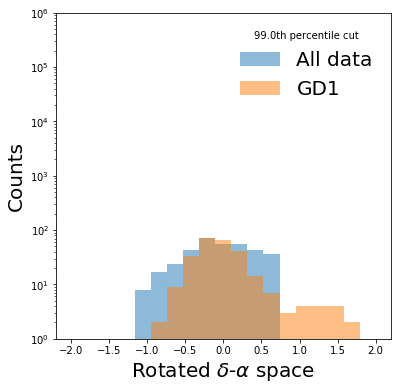

In [168]:
for i in range(20):
    
    print(str(i) + '\n\n\n')
    #Build model
    model = Sequential()
    model.add(Dense(64, input_dim=3, activation='relu')) 
    #model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train[:,1:],Y_train, epochs=20, batch_size=200,validation_data=(X_test[:,1:],Y_test))
    
    #plot loss
    plt.clf()
    plt.plot(history.history['loss']) #training
    plt.plot(history.history['val_loss']) #testing
    plt.show()
    
    preds = model.predict(X_test[:,1:6], batch_size=int(0.1*len(X_test)))
    
    #plot
    plt.clf()
    plt.hist(preds[Y_test==1],alpha=0.5,bins=np.linspace(0,1,20),label="SR",density=True)
    plt.hist(preds[Y_test==0],alpha=0.5,bins=np.linspace(0,1,20),label="SB",density=True)
    plt.legend(frameon=False)
    plt.yscale("log")
    plt.xlabel("NN")
    plt.show()
    
    preds_GD1 = model.predict(GD1_scaled[:,1:6], batch_size=int(0.1*len(GD1_scaled)))
    
    #plot GD1 and all data
    for cut in [0.,0.5,0.9,0.99]:
        X_pass = X_test[(Y_test==1)*(preds[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
        X_pass_GD1 = GD1_scaled[preds_GD1[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]

        plt.clf()
        plt.figure(figsize=(6,6))
        plt.hist(X_pass[:,1],label="All data",alpha=0.5,bins=np.linspace(-2,2,20))
        plt.hist(X_pass_GD1[:,1],label="GD1",alpha=0.5,bins=np.linspace(-2,2,20))
        plt.yscale("log")
        plt.legend(frameon=False,title=str(100*cut)+"th percentile cut",fontsize=20)
        plt.ylim([1,1e6])
        plt.ylabel("Counts",fontsize=20)
        plt.xlabel(r"Rotated $\delta$-$\alpha$ space",fontsize=20)
        plt.show()
    
    from sklearn.metrics import roc_curve, auc,roc_auc_score
    fpr, tpr, thresholds = roc_curve(np.concatenate([np.zeros(len(preds)),np.ones(len(preds_GD1))]), np.concatenate([preds,preds_GD1]))
    
    #plot improvement vs true positive
    plt.clf()
    plt.plot(tpr,tpr/fpr**0.5)
    plt.xlabel("True Positive Rate")
    plt.ylabel("Significance Improvement")
    plt.show()

    for cut in [0.,0.5,0.9,0.99]:
        X_pass = X_test[(Y_test==1)*(preds[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
        X_pass_GD1 = GD1_scaled[preds_GD1[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]
    
        plt.clf()
        plt.figure(figsize=(6,6))
        plt.hist(X_pass[:,0],label="All data",alpha=0.5,bins=np.linspace(-2,2,20))
        plt.hist(X_pass_GD1[:,0],label="GD1",alpha=0.5,bins=np.linspace(-2,2,20))
        plt.yscale("log")
        plt.legend(frameon=False,title=str(100*cut)+"th percentile cut",fontsize=20)
        plt.ylim([1,1e6])
        plt.ylabel("Counts",fontsize=20)
        plt.xlabel(r"Rotated $\delta$-$\alpha$ space",fontsize=20)
        plt.show()
        
    print('\n\n\n\n\n')
    
    

In [151]:
#put a loop and check to make sure it has good output consistently
#write out the neural network - can save neural network architecture and weights,biases and load it back in
#eats up memory - clear session clear_session()

#data visualization - for stream (gaiadata3) and background + stream (gaiadata2) for all the dimensions
#add more dimensions?
    #change 3 to 6
    #X_train needs to be modified, so we have to change how we set up the data in the earlier cells

#run for 100 epochs to see overfitting

model = Sequential()
model.add(Dense(64, input_dim=3, activation='relu')) 
#model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train[:,1:],Y_train, epochs=100, batch_size=200,validation_data=(X_test[:,1:],Y_test))

Train on 71263 samples, validate on 71264 samples
Epoch 1/100
71263/71263 [==============================] - 3s 43us/step - loss: 0.6937 - acc: 0.4982 - val_loss: 0.6938 - val_acc: 0.4979
Epoch 2/100
71263/71263 [==============================] - 3s 36us/step - loss: 0.6932 - acc: 0.5030 - val_loss: 0.6931 - val_acc: 0.5058
Epoch 3/100
71263/71263 [==============================] - 2s 35us/step - loss: 0.6932 - acc: 0.5016 - val_loss: 0.6930 - val_acc: 0.5041
Epoch 4/100
71263/71263 [==============================] - 2s 34us/step - loss: 0.6931 - acc: 0.5024 - val_loss: 0.6931 - val_acc: 0.5004
Epoch 5/100
71263/71263 [==============================] - 3s 35us/step - loss: 0.6930 - acc: 0.5038 - val_loss: 0.6927 - val_acc: 0.5067
Epoch 6/100
71263/71263 [==============================] - 2s 35us/step - loss: 0.6929 - acc: 0.5075 - val_loss: 0.6930 - val_acc: 0.5061
Epoch 7/100
71263/71263 [==============================] - 2s 34us/step - loss: 0.6928 - acc: 0.5068 - val_loss: 0.6926 - 

71263/71263 [==============================] - 2s 34us/step - loss: 0.6899 - acc: 0.5251 - val_loss: 0.6927 - val_acc: 0.5143
Epoch 60/100
71263/71263 [==============================] - 3s 35us/step - loss: 0.6895 - acc: 0.5285 - val_loss: 0.6929 - val_acc: 0.5116
Epoch 61/100
71263/71263 [==============================] - 2s 34us/step - loss: 0.6898 - acc: 0.5241 - val_loss: 0.6931 - val_acc: 0.5089
Epoch 62/100
71263/71263 [==============================] - 2s 34us/step - loss: 0.6897 - acc: 0.5258 - val_loss: 0.6933 - val_acc: 0.5081
Epoch 63/100
71263/71263 [==============================] - 2s 35us/step - loss: 0.6897 - acc: 0.5263 - val_loss: 0.6931 - val_acc: 0.5139
Epoch 64/100
71263/71263 [==============================] - 2s 35us/step - loss: 0.6897 - acc: 0.5270 - val_loss: 0.6931 - val_acc: 0.5141
Epoch 65/100
71263/71263 [==============================] - 3s 35us/step - loss: 0.6896 - acc: 0.5280 - val_loss: 0.6934 - val_acc: 0.5084
Epoch 66/100
71263/71263 [==============

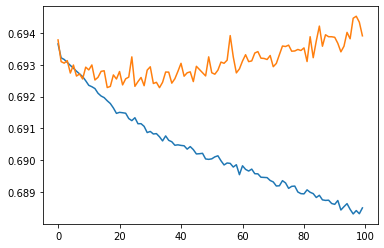

In [161]:
plt.plot(history.history['loss']) #training
plt.plot(history.history['val_loss']) #testing

In [153]:
preds = model.predict(X_test[:,1:6], batch_size=int(0.1*len(X_test)))

Text(0.5, 0, 'NN')

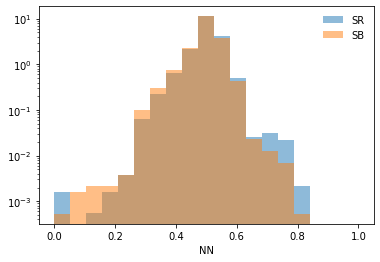

In [154]:
plt.hist(preds[Y_test==1],alpha=0.5,bins=np.linspace(0,1,20),label="SR",density=True)
plt.hist(preds[Y_test==0],alpha=0.5,bins=np.linspace(0,1,20),label="SB",density=True)
plt.legend(frameon=False)
plt.yscale("log")
plt.xlabel("NN")

In [155]:
preds_GD1 = model.predict(GD1_scaled[:,1:6], batch_size=int(0.1*len(GD1_scaled)))

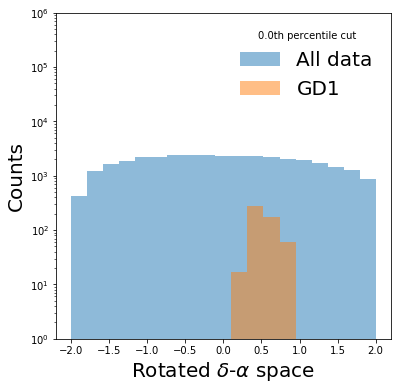

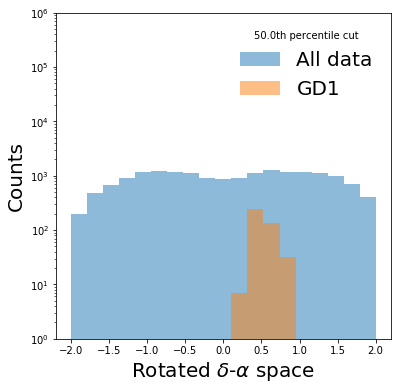

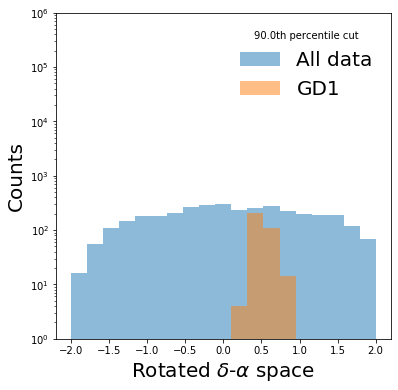

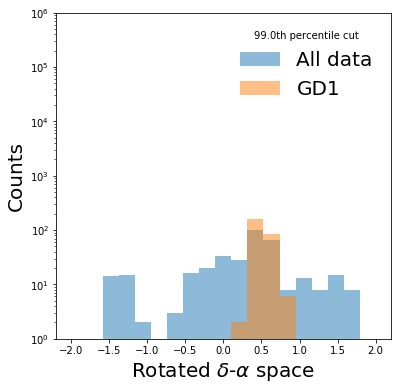

In [156]:
for cut in [0.,0.5,0.9,0.99]:
    X_pass = X_test[(Y_test==1)*(preds[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
    X_pass_GD1 = GD1_scaled[preds_GD1[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]

    plt.figure(figsize=(6,6))
    plt.hist(X_pass[:,1],label="All data",alpha=0.5,bins=np.linspace(-2,2,20))
    plt.hist(X_pass_GD1[:,1],label="GD1",alpha=0.5,bins=np.linspace(-2,2,20))
    plt.yscale("log")
    plt.legend(frameon=False,title=str(100*cut)+"th percentile cut",fontsize=20)
    plt.ylim([1,1e6])
    plt.ylabel("Counts",fontsize=20)
    plt.xlabel(r"Rotated $\delta$-$\alpha$ space",fontsize=20)

In [157]:
from sklearn.metrics import roc_curve, auc,roc_auc_score

In [158]:
fpr, tpr, thresholds = roc_curve(np.concatenate([np.zeros(len(preds)),np.ones(len(preds_GD1))]), np.concatenate([preds,preds_GD1]))

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Significance Improvement')

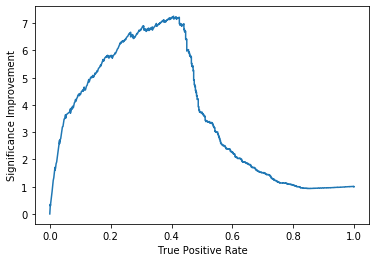

In [159]:
plt.plot(tpr,tpr/fpr**0.5)
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")

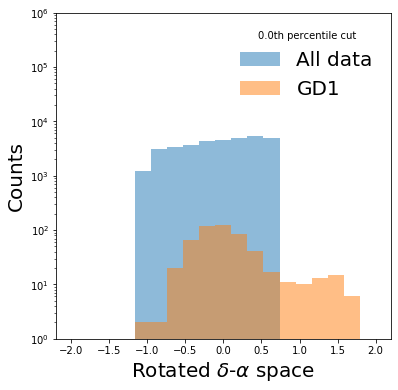

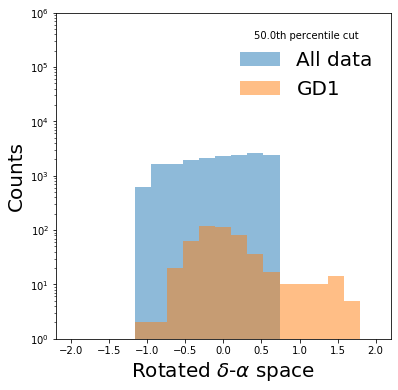

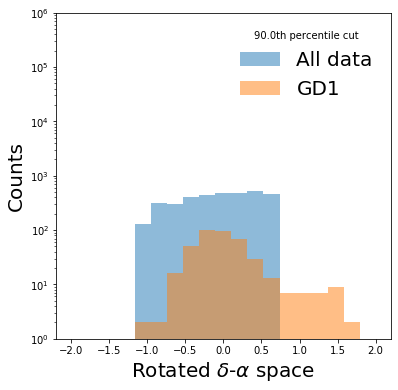

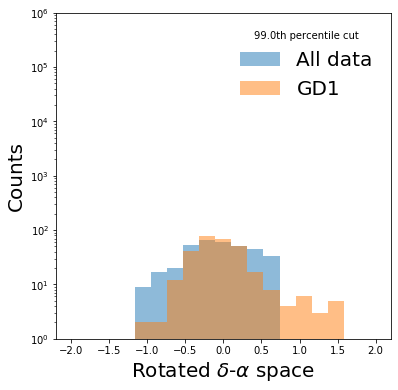

In [110]:
for cut in [0.,0.5,0.9,0.99]:
    X_pass = X_test[(Y_test==1)*(preds[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
    X_pass_GD1 = GD1_scaled[preds_GD1[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]

    plt.figure(figsize=(6,6))
    plt.hist(X_pass[:,0],label="All data",alpha=0.5,bins=np.linspace(-2,2,20))
    plt.hist(X_pass_GD1[:,0],label="GD1",alpha=0.5,bins=np.linspace(-2,2,20))
    plt.yscale("log")
    plt.legend(frameon=False,title=str(100*cut)+"th percentile cut",fontsize=20)
    plt.ylim([1,1e6])
    plt.ylabel("Counts",fontsize=20)
    plt.xlabel(r"Rotated $\delta$-$\alpha$ space",fontsize=20)

In [90]:
#Repeat with GD1 removed.

In [115]:
np.shape(gaiadata2)

(1032672, 6)

In [187]:
#put a loop and check to make sure it has good output consistently
#write out the neural network - can save neural network architecture and weights,biases and load it back in
#eats up memory - clear session clear_session()

#data visualization - for stream (gaiadata3) and background + stream (gaiadata2) for all the dimensions
#add more dimensions?
    #change 3 to 6
    #X_train needs to be modified, so we have to change how we set up the data in the earlier cells

#run for 100 epochs to see overfitting

print(gaiadata2.shape)
X = np.concatenate([SR,SB,GD1])
Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB)),2.*np.ones(len(GD1))])
X_scaled = preprocessing.scale(X)
print(SR.shape)
print(SB.shape)
print(GD1.shape)
print(X.shape)
print(X_scaled.shape)
GD1_scaled = X_scaled[Y==2]
X_scaled = X_scaled[Y<2]
Y = Y[Y<2]
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5)
print(X_train[:, :].shape)

# model = Sequential()
# model.add(Dense(64, input_dim=6, activation='relu')) 
# #model.add(Dropout(0.2))
# model.add(Dense(64, activation='relu'))
# #model.add(Dropout(0.2))
# model.add(Dense(64, activation='relu'))
# #model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# history = model.fit(X_train[:,1:],Y_train, epochs=100, batch_size=200,validation_data=(X_test[:,1:],Y_test))

(1032672, 6)
(70835, 4)
(71692, 4)
(531, 4)
(143058, 4)
(143058, 4)
(71263, 4)


/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


0



Train on 71263 samples, validate on 71264 samples
Epoch 1/20
71263/71263 [==============================] - 7s 96us/step - loss: 0.6941 - acc: 0.4975 - val_loss: 0.6935 - val_acc: 0.4962
Epoch 2/20
71263/71263 [==============================] - 4s 50us/step - loss: 0.6935 - acc: 0.4999 - val_loss: 0.6931 - val_acc: 0.5068
Epoch 3/20
71263/71263 [==============================] - 3s 47us/step - loss: 0.6933 - acc: 0.5011 - val_loss: 0.6931 - val_acc: 0.5049
Epoch 4/20
71263/71263 [==============================] - 3s 46us/step - loss: 0.6933 - acc: 0.4978 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 5/20
71263/71263 [==============================] - 3s 48us/step - loss: 0.6932 - acc: 0.5001 - val_loss: 0.6933 - val_acc: 0.4955
Epoch 6/20
71263/71263 [==============================] - 3s 46us/step - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6931 - val_acc: 0.4979
Epoch 7/20
71263/71263 [==============================] - 3s 48us/step - loss: 0.6932 - acc: 0.5016 - val_loss: 0.6931 - va

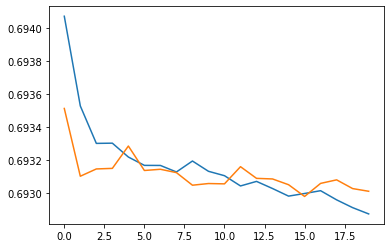

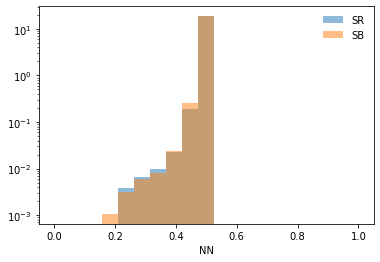

<Figure size 432x288 with 0 Axes>

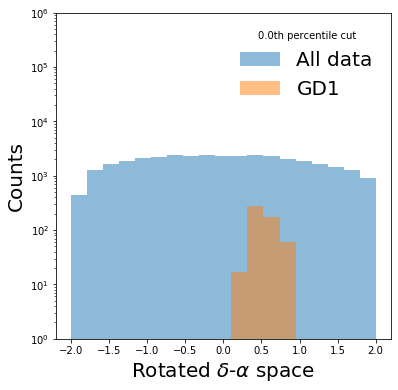

<Figure size 432x288 with 0 Axes>

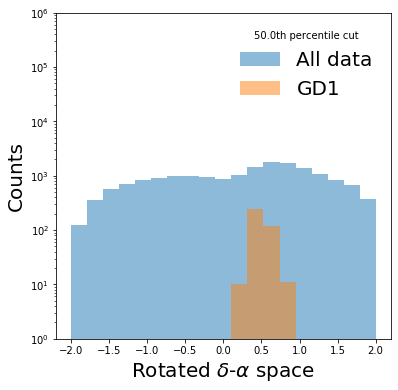

<Figure size 432x288 with 0 Axes>

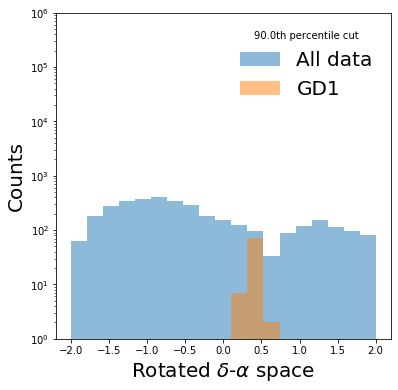

<Figure size 432x288 with 0 Axes>

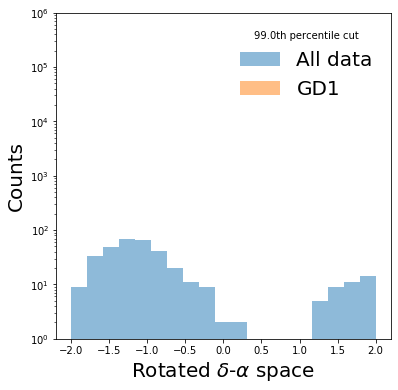

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


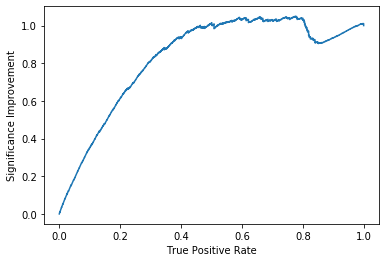

<Figure size 432x288 with 0 Axes>

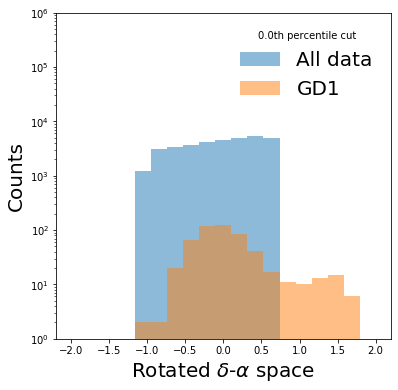

<Figure size 432x288 with 0 Axes>

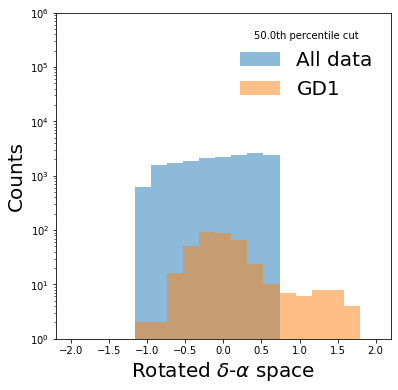

<Figure size 432x288 with 0 Axes>

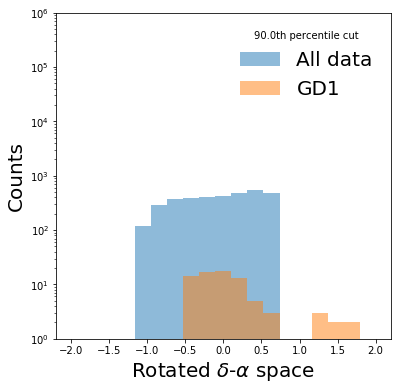

<Figure size 432x288 with 0 Axes>

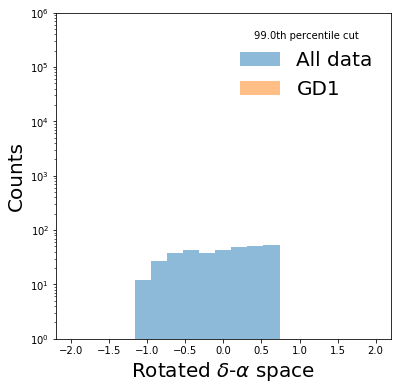

In [193]:
for i in range(1):
    
    print(str(i) + '\n\n\n')
    #Build model
    model = Sequential()
    model.add(Dense(64, input_dim=3, activation='relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
#     model.add(Dense(64, input_dim=3, activation='relu')) 
#     model.add(Dense(64, input_dim=3, activation='relu')) 
#     model.add(Dense(64, input_dim=3, activation='relu')) 
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train[:,1:],Y_train, epochs=20, batch_size=200,validation_data=(X_test[:,1:],Y_test))
    
    #plot loss
    plt.clf()
    plt.plot(history.history['loss']) #training
    plt.plot(history.history['val_loss']) #testing
    plt.show()
    
    preds = model.predict(X_test[:,1:6], batch_size=int(0.1*len(X_test)))
    
    #plot
    plt.clf()
    plt.hist(preds[Y_test==1],alpha=0.5,bins=np.linspace(0,1,20),label="SR",density=True)
    plt.hist(preds[Y_test==0],alpha=0.5,bins=np.linspace(0,1,20),label="SB",density=True)
    plt.legend(frameon=False)
    plt.yscale("log")
    plt.xlabel("NN")
    plt.show()
    
    preds_GD1 = model.predict(GD1_scaled[:,1:6], batch_size=int(0.1*len(GD1_scaled)))
    
    #plot GD1 and all data
    for cut in [0.,0.5,0.9,0.99]:
        X_pass = X_test[(Y_test==1)*(preds[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
        X_pass_GD1 = GD1_scaled[preds_GD1[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]

        plt.clf()
        plt.figure(figsize=(6,6))
        plt.hist(X_pass[:,1],label="All data",alpha=0.5,bins=np.linspace(-2,2,20))
        plt.hist(X_pass_GD1[:,1],label="GD1",alpha=0.5,bins=np.linspace(-2,2,20))
        plt.yscale("log")
        plt.legend(frameon=False,title=str(100*cut)+"th percentile cut",fontsize=20)
        plt.ylim([1,1e6])
        plt.ylabel("Counts",fontsize=20)
        plt.xlabel(r"Rotated $\delta$-$\alpha$ space",fontsize=20)
        plt.show()
    
    from sklearn.metrics import roc_curve, auc,roc_auc_score
    fpr, tpr, thresholds = roc_curve(np.concatenate([np.zeros(len(preds)),np.ones(len(preds_GD1))]), np.concatenate([preds,preds_GD1]))
    
    #plot improvement vs true positive
    plt.clf()
    plt.plot(tpr,tpr/fpr**0.5)
    plt.xlabel("True Positive Rate")
    plt.ylabel("Significance Improvement")
    plt.show()

    for cut in [0.,0.5,0.9,0.99]:
        X_pass = X_test[(Y_test==1)*(preds[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
        X_pass_GD1 = GD1_scaled[preds_GD1[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]
    
        plt.clf()
        plt.figure(figsize=(6,6))
        plt.hist(X_pass[:,0],label="All data",alpha=0.5,bins=np.linspace(-2,2,20))
        plt.hist(X_pass_GD1[:,0],label="GD1",alpha=0.5,bins=np.linspace(-2,2,20))
        plt.yscale("log")
        plt.legend(frameon=False,title=str(100*cut)+"th percentile cut",fontsize=20)
        plt.ylim([1,1e6])
        plt.ylabel("Counts",fontsize=20)
        plt.xlabel(r"Rotated $\delta$-$\alpha$ space",fontsize=20)
        plt.show()
        
    print('\n\n\n\n\n')
    